In [1]:
import numpy as np
import pandas as pd
import torch
from scLENS import scLENS

import cProfile, pstats
import umap
import umap.plot

from sklearn.metrics import rand_score, normalized_mutual_info_score
from clusim.clustering import Clustering
import clusim.sim as sim

import matplotlib.pyplot as plt
import seaborn as sns

import re
from scLENS.clustering import scSHC, find_clusters
import anndata
import scanpy as sc

/home/sclens/miniconda3/envs/sclens/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sclens/miniconda3/envs/sclens/lib/python3.9/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/home/sclens/miniconda3/envs/sclens/lib/python3.9/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/sclens/miniconda3/envs/sclens/lib/

# Params

In [2]:
  # Method-agnostic hyperparameters
params = {'resolutions': np.arange(0.1, 2, 0.1), #np.arange(0.05, 2, 0.05), # [0.3, 0.5, 0.8, 1, 1.2, 1.6, 2, 4, 6, 8],
          'reps': 10,
          'n_jobs': -1}

In [3]:
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray', 'tab:olive', 'tab:cyan', 'k']

# Display Helper

In [4]:
def display_mappings(X, clusterings, names):
  mapper = umap.UMAP(metric='cosine').fit_transform(X)

  fig, axs = plt.subplots(1, len(clusterings), figsize=(40, 10))
  for ax, cls in enumerate(clusterings):
    labels = np.unique(cls)
    for i, l in enumerate(labels):
      idx = np.where(cls == l)
      axs[ax].scatter(mapper[idx, 0], mapper[idx, 1], s=2, label=l)

    axs[ax].legend()
    axs[ax].set_xlabel('UMAP1')
    axs[ax].set_ylabel('UMAP2')
    axs[ax].tick_params(axis='both',
                  which='both',
                  bottom=False,
                  top=False,
                  labelbottom=False,
                  labelleft=False)
    axs[ax].set_title(names[ax])
  plt.show()

# Evaluate Func

In [5]:
def evaluate(filepaths, save_scl, overwrite=False, **params):
  scl_pool = []

  for file in filepaths:
    if overwrite or save.loc[file].isnull().all():
      print(file)
      if 'sim' in file:
        alpha = 0.05
      else:
        alpha = 0.25

      df = pd.read_csv(file)
      y_true_full = df['cell']
      df = df.drop('cell', axis=1)

      try:
        sclens = scLENS(device=torch.device('cuda:0'))
        sclens.preprocess(df)
        X_transform = sclens.fit_transform()
      except torch.cuda.OutOfMemoryError:
        del sclens
        torch.cuda.empty_cache()
        print('Out of memory, retrying on CPU')
        
        sclens = scLENS(device=torch.device('cpu'))
        sclens.preprocess(df)
        X_transform = sclens.fit_transform()

      sch_scl = sclens.cluster(df, method='scSHC', alpha=alpha, n_jobs=-1)

      sch_cls_scl = Clustering().from_membership_list(sch_scl)
      true_cls = Clustering().from_membership_list(y_true_full)

      display_mappings(X_transform, [y_true_full, sch_scl], ['True', 'scLENS + scSHC'])

      scl_score = sim.element_sim(true_cls, sch_cls_scl)

      scl_pool.append(scl_score)

      scores = {'scLENS + scSHC': scl_score}
      schemes = ['Element-Centric Clustering']

      x = np.arange(len(schemes))
      width = 0.25
      multiplier = 0

      fig, ax = plt.subplots(layout='constrained')

      for name, val in scores.items():
          offset = width * multiplier
          rects = ax.bar(x + offset, val, width, label=name)
          ax.bar_label(rects, padding=2)
          multiplier += 1

      ax.set_ylabel('Score')
      ax.set_title(' '.join(file.split('/')[2:]))
      ax.set_xticks(x + width/2, schemes)
      ax.legend(loc='upper right', ncols=2)

      plt.show()
      del sclens, X_transform, sch_scl, sch_cls_scl, true_cls, df, y_true_full, scores, schemes
      torch.cuda.empty_cache()

      save_scl.loc[file, 'ECC'] = scl_score
      save_scl.to_csv('scSHC_scores.csv')

  return scl_pool

# Run Dataset Evaluation

In [6]:
import os

filepaths = []

for dir in os.listdir('data'):
  if dir.endswith('.csv.gz'):
    filepaths.append(os.path.join('data', dir))
  else:
    for dir2 in os.listdir(os.path.join('data', dir)):
      if dir2.endswith('.csv.gz'):
        filepaths.append(os.path.join('data', dir, dir2))
      else:
        for f in os.listdir(os.path.join('data', dir, dir2)):
          if f.endswith('.csv.gz'):
            filepaths.append(os.path.join('data', dir, dir2, f))

filepaths

['data/Zheng_real_data/Imbalanced/z_data_3706.csv.gz',
 'data/Zheng_real_data/Imbalanced/z_data_4757.csv.gz',
 'data/Zheng_real_data/Imbalanced/z_data_4292.csv.gz',
 'data/Zheng_real_data/Imbalanced/z_data_5730.csv.gz',
 'data/Zheng_real_data/Imbalanced/z_data_4952.csv.gz',
 'data/Zheng_real_data/Balanced/z_data_12073.csv.gz',
 'data/Zheng_real_data/Balanced/z_data_3869.csv.gz',
 'data/Zheng_real_data/Balanced/z_data_7993.csv.gz',
 'data/Zheng_real_data/Balanced/z_data_2410.csv.gz',
 'data/Zheng_real_data/Balanced/z_data_785.csv.gz',
 'data/sim_Tcell/2250-1220.csv.gz',
 'data/sim_Tcell/5930-3210.csv.gz',
 'data/sim_Tcell/2251-1179.csv.gz',
 'data/sim_Tcell/3276-1042.csv.gz',
 'data/sim_Tcell/2972-1523.csv.gz',
 'data/sim_Tcell/4249-2916.csv.gz',
 'data/sim_Tcell/4320-2134.csv.gz',
 'data/sim_Tcell/3689-1878.csv.gz',
 'data/sim_Tcell/5974-3858.csv.gz',
 'data/sim_Tcell/6006-2261.csv.gz',
 'data/sim_Tcell/6083-4496.csv.gz',
 'data/sim_Tcell/4797-2332.csv.gz',
 'data/sim_Tcell/5960-1400.c

In [7]:
if not os.path.exists('scSHC_scores.csv'):
  save = pd.DataFrame(index=filepaths, columns=['ECC'])
  save.to_csv('scSHC_scores.csv')
else:
  save = pd.read_csv('scSHC_scores.csv', index_col=0)

In [8]:
save

,ECC
data/Zheng_real_data/Imbalanced/z_data_3706.csv.gz,0.521790
data/Zheng_real_data/Imbalanced/z_data_4757.csv.gz,0.616004
data/Zheng_real_data/Imbalanced/z_data_4292.csv.gz,0.636985
data/Zheng_real_data/Imbalanced/z_data_5730.csv.gz,0.722414
data/Zheng_real_data/Imbalanced/z_data_4952.csv.gz,0.523888
data/Zheng_real_data/Balanced/z_data_12073.csv.gz,0.629252
data/Zheng_real_data/Balanced/z_data_3869.csv.gz,0.466949
data/Zheng_real_data/Balanced/z_data_7993.csv.gz,0.639709
data/Zheng_real_data/Balanced/z_data_2410.csv.gz,0.348483
data/Zheng_real_data/Balanced/z_data_785.csv.gz,0.125429


In [9]:
torch.cuda.empty_cache()

data/sim_T_muris/balanced/T_muris_3966.csv.gz


100%|██████████| 10/10 [02:53<00:00, 17.34s/it]
/home/sclens/Documents/scLENS-py/scLENS/scLENS.py:319: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_clean = torch.tensor(X).to(self.device, dtype=torch.double)


ClusterID: 7930, Test Shape: (3966, 13556)
Mean: 33.58404743192265 Std: 1.3710389499421922 Score: 87.92086836181554
ClusterID: 7929, Test Shape: (1992, 12586)
Mean: 32.79499704276945 Std: 1.9946981022382935 Score: 61.66639340271295
ClusterID: 7927, Test Shape: (1198, 11700)
Mean: 44.287329650382404 Std: 0.4238455627150485 Score: 46.83006023695111
ClusterID: 7924, Test Shape: (772, 10340)
Mean: 39.06453902866174 Std: 0.2357238605828733 Score: 39.23339310008443
CLUSTER IDENTIFIED; Significance: 0.23689642438910802, Total clusters: 1
ClusterID: 7911, Test Shape: (426, 10542)
Mean: 27.855642513856765 Std: 1.2443220441064275 Score: 22.808636632197405
CLUSTER IDENTIFIED; Significance: 0.9999750429319856, Total clusters: 2
ClusterID: 7922, Test Shape: (794, 9974)


Traceback (most recent call last):
  File "/home/sclens/miniconda3/envs/sclens/lib/python3.9/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 281, in main
    registry[rtype][name] -= 1
KeyError: '/dev/shm/joblib_memmapping_folder_106041_7d936689284b47db845a6a0ff81ccf1a_8c1a65e711e741428138430430309007/106041-134421785809440-4fd7f4cccbe541a39c0b7d88e3201699.pkl'


Mean: 35.107807672456694 Std: 1.604612225628247 Score: 39.59166129730815
ClusterID: 7918, Test Shape: (373, 8817)
Mean: 25.725541064626405 Std: 0.771480465329278 Score: 12.699548408883443
CLUSTER IDENTIFIED; Significance: 1.0, Total clusters: 3
ClusterID: 7882, Test Shape: (421, 8637)
Mean: 27.332106659535118 Std: 1.8492844201919805 Score: 26.949500917979687
CLUSTER IDENTIFIED; Significance: 0.5819536557006075, Total clusters: 4
ClusterID: 7928, Test Shape: (1974, 11407)
Mean: 32.42529581553063 Std: 1.6262232599133284 Score: 60.529701397749086
ClusterID: 7926, Test Shape: (1192, 10633)
Mean: 33.37415041442149 Std: 0.5424566909252778 Score: 44.91885372188193
ClusterID: 7925, Test Shape: (823, 10154)
Mean: 32.28895407005993 Std: 0.8958903896147177 Score: 40.40253707456293
ClusterID: 7914, Test Shape: (383, 9643)
Mean: 25.885935366784576 Std: 1.7541619731554052 Score: 25.076648125958005
CLUSTER IDENTIFIED; Significance: 0.6777271846006369, Total clusters: 5
ClusterID: 7912, Test Shape: (4

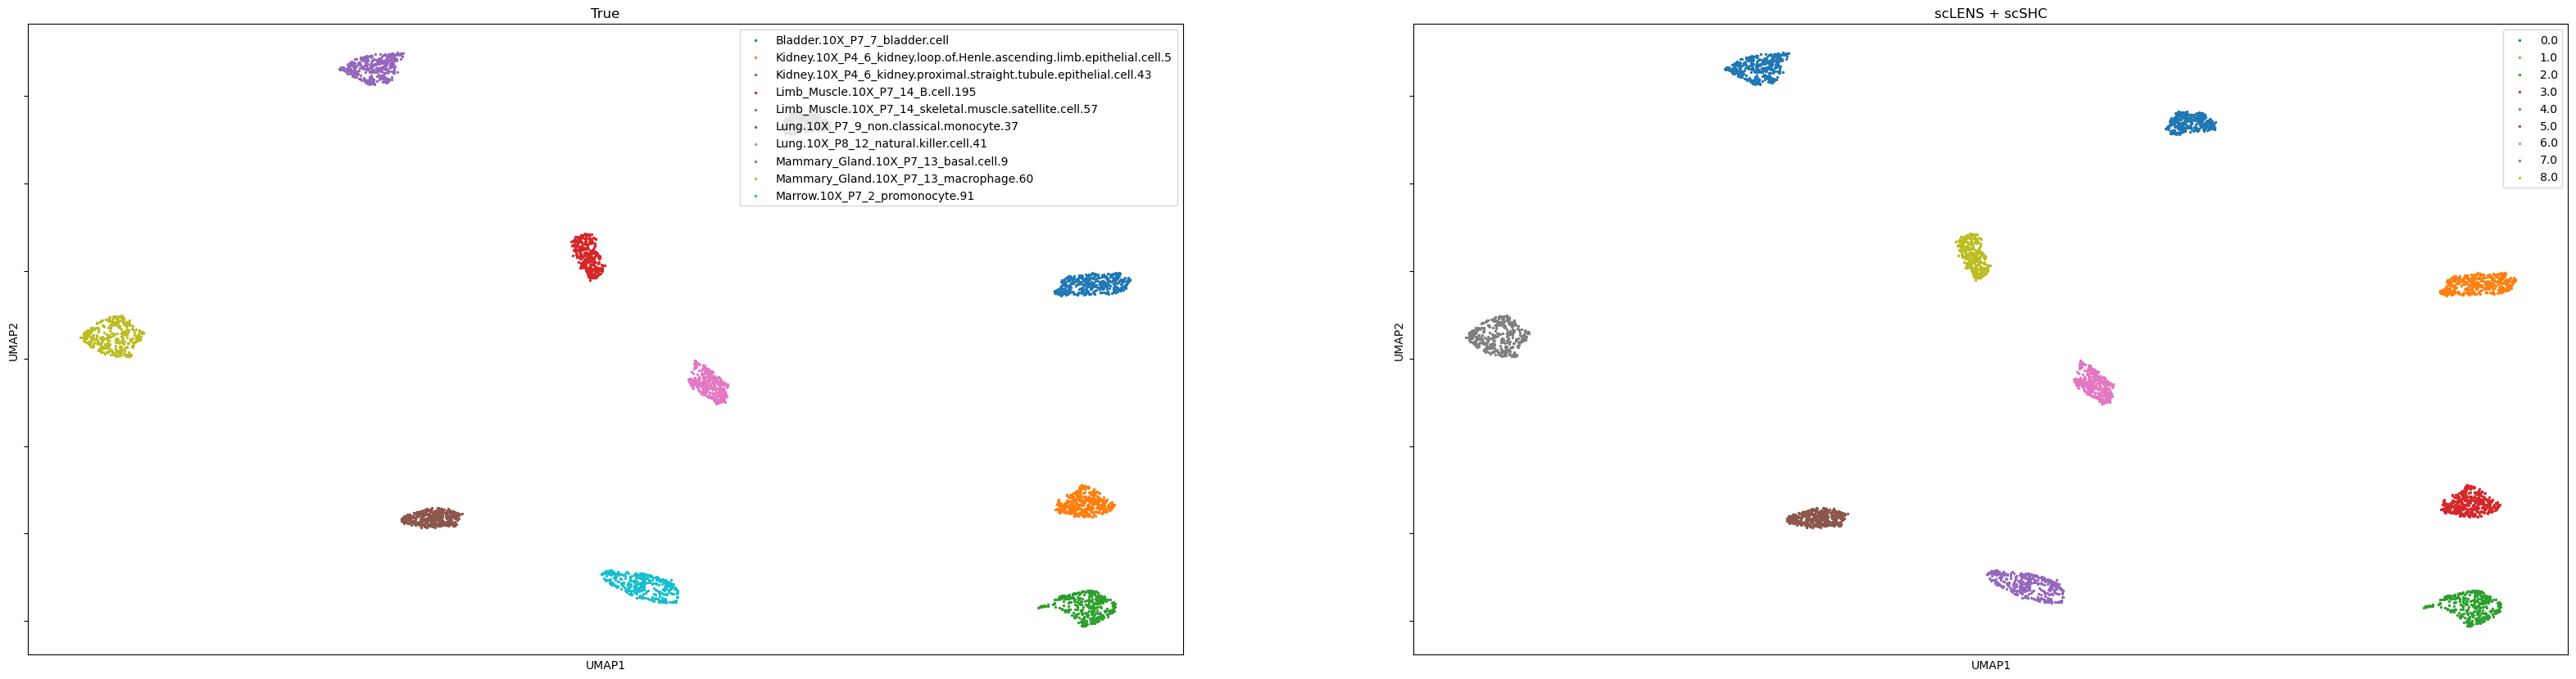

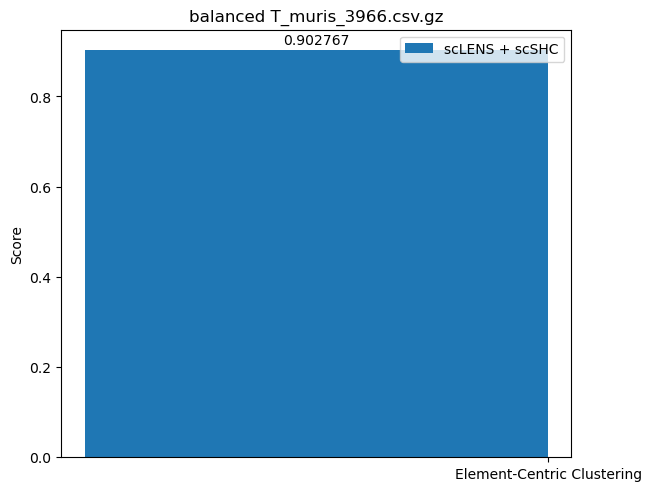

data/Z8eq.csv.gz


100%|██████████| 10/10 [01:01<00:00,  6.18s/it]
/home/sclens/Documents/scLENS-py/scLENS/scLENS.py:319: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_clean = torch.tensor(X).to(self.device, dtype=torch.double)


ClusterID: 7986, Test Shape: (3994, 9651)
Mean: 40.12288219509611 Std: 1.859168466698949 Score: 87.83389213515851
ClusterID: 7985, Test Shape: (1693, 9604)
Mean: 41.553618501015514 Std: 1.2875868570199331 Score: 52.78418560861472
ClusterID: 7984, Test Shape: (1191, 9549)
Mean: 42.1645746771641 Std: 0.9750279468010281 Score: 48.78453530707192
ClusterID: 7978, Test Shape: (597, 8854)
Mean: 33.54139297836981 Std: 0.7529614107510931 Score: 16.799520071817824
CLUSTER IDENTIFIED; Significance: 1.0, Total clusters: 1
ClusterID: 7968, Test Shape: (594, 9221)
Mean: 32.609246208304896 Std: 2.4605705266522815 Score: 24.38853200674608
CLUSTER IDENTIFIED; Significance: 0.9995825821575137, Total clusters: 2
ClusterID: 7974, Test Shape: (502, 8996)
Mean: 31.14606333134102 Std: 0.3943066552624594 Score: 21.15988886063473
CLUSTER IDENTIFIED; Significance: 1.0, Total clusters: 3
ClusterID: 7983, Test Shape: (2301, 9448)
Mean: 42.84993030664584 Std: 1.7259494271976275 Score: 57.13730695149801
ClusterID: 

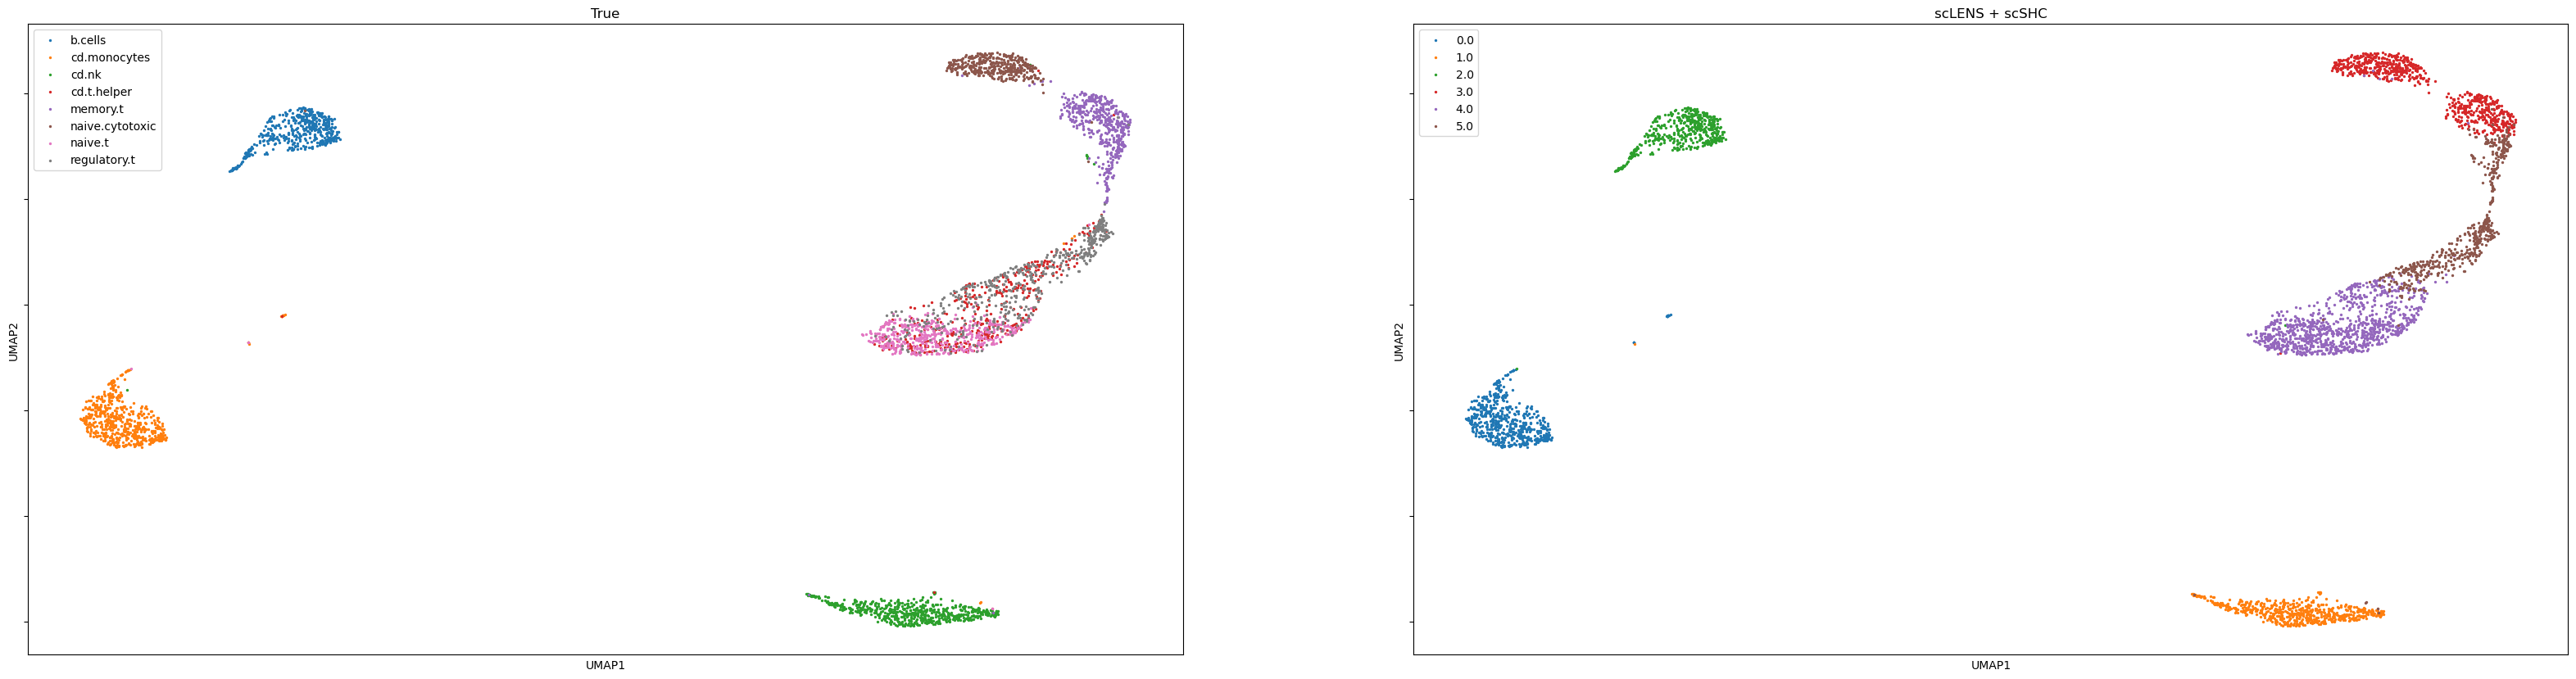

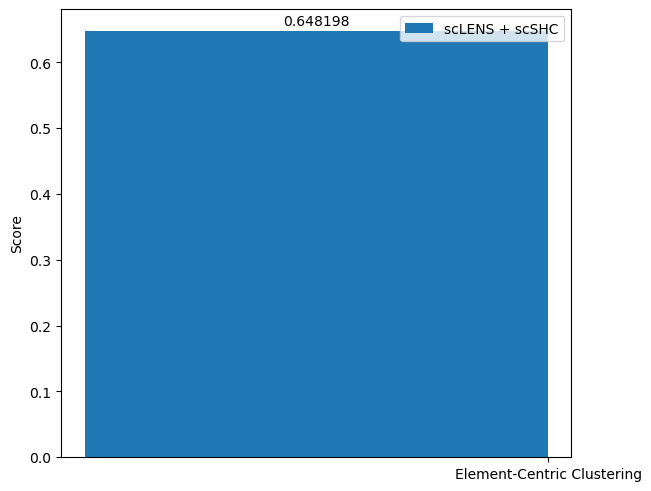

In [10]:
chsr_score, mltk_score = evaluate(filepaths, save, overwrite=False, **params)

In [11]:
save.mean()

ECC    0.53853
dtype: float64

# Load Scores, Compare

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Arial'

### scLENS

In [12]:
# save_rand_nmi = pd.read_csv('RandIndex_NMI.csv', index_col=0)
# save_rand_nmi

In [13]:
save_ecc = pd.read_csv('save.csv', index_col=0)

In [14]:
# scl_scores = pd.concat([save_ecc, save_rand_nmi], axis=1)
scl_scores = save_ecc
# scl_scores = scl_scores.drop(['ChooseR_ECC'], axis=1)
scl_scores.index = [x.replace('scLENS/', '') for x in scl_scores.index]
scl_scores

,MultiK_ECC,ChooseR_ECC
data/Z8eq.csv.gz,0.770602,0.636209
data/sim_T_muris/balanced/T_muris_1019.csv.gz,1.000000,1.000000
data/sim_T_muris/balanced/T_muris_2006.csv.gz,0.997038,0.997038
data/sim_T_muris/balanced/T_muris_3016.csv.gz,1.000000,1.000000
data/sim_T_muris/balanced/T_muris_3966.csv.gz,1.000000,1.000000
data/sim_T_muris/balanced/T_muris_5033.csv.gz,1.000000,1.000000
data/sim_T_muris/imbalanced/tmp_1.csv.gz,1.000000,1.000000
data/sim_T_muris/imbalanced/tmp_2.csv.gz,1.000000,1.000000
data/sim_T_muris/imbalanced/tmp_3.csv.gz,1.000000,0.790384
data/sim_T_muris/imbalanced/tmp_4.csv.gz,0.998620,0.973251


In [15]:
scshc_scl = pd.read_csv('scSHC_scores.csv', index_col=0)
scshc_scl = scshc_scl.rename({'ECC': 'scSHC_ECC'}, axis=1)
scl_scores = scl_scores.join(scshc_scl)

In [16]:
scl_scores

,MultiK_ECC,ChooseR_ECC,scSHC_ECC
data/Z8eq.csv.gz,0.770602,0.636209,0.648198
data/sim_T_muris/balanced/T_muris_1019.csv.gz,1.000000,1.000000,0.200898
data/sim_T_muris/balanced/T_muris_2006.csv.gz,0.997038,0.997038,0.300560
data/sim_T_muris/balanced/T_muris_3016.csv.gz,1.000000,1.000000,0.603703
data/sim_T_muris/balanced/T_muris_3966.csv.gz,1.000000,1.000000,0.902767
data/sim_T_muris/balanced/T_muris_5033.csv.gz,1.000000,1.000000,1.000000
data/sim_T_muris/imbalanced/tmp_1.csv.gz,1.000000,1.000000,0.648226
data/sim_T_muris/imbalanced/tmp_2.csv.gz,1.000000,1.000000,0.799713
data/sim_T_muris/imbalanced/tmp_3.csv.gz,1.000000,0.790384,0.687832
data/sim_T_muris/imbalanced/tmp_4.csv.gz,0.998620,0.973251,0.725332


In [17]:
scl_scores.mean()

MultiK_ECC     0.719685
ChooseR_ECC    0.683380
scSHC_ECC      0.538530
dtype: float64

In [18]:
noscl_scores = pd.read_csv('save_no_sclens.csv', index_col=0)
noscl_scores = noscl_scores.drop(['MultiK_RandIndex', 'MultiK_NormMI'], axis=1)
noscl_scores.index = [x.replace('scLENS/', '') for x in noscl_scores.index]
noscl_scores

,MultiK_ECC
data/Z8eq.csv.gz,0.523678
data/sim_T_muris/balanced/T_muris_1019.csv.gz,0.572166
data/sim_T_muris/balanced/T_muris_2006.csv.gz,0.595791
data/sim_T_muris/balanced/T_muris_3016.csv.gz,0.642562
data/sim_T_muris/balanced/T_muris_3966.csv.gz,0.731693
data/sim_T_muris/balanced/T_muris_5033.csv.gz,0.633688
data/sim_T_muris/imbalanced/tmp_1.csv.gz,0.929867
data/sim_T_muris/imbalanced/tmp_2.csv.gz,0.854473
data/sim_T_muris/imbalanced/tmp_3.csv.gz,0.672994
data/sim_T_muris/imbalanced/tmp_4.csv.gz,0.667344


In [19]:
chsr_noscl = pd.read_csv('chooseR_noscl_scores.csv', index_col=0)
chsr_noscl = chsr_noscl.rename({'ECC': 'ChooseR_ECC'}, axis=1)
noscl_scores = noscl_scores.join(chsr_noscl)

In [20]:
scshc_noscl = pd.read_csv('scSHC_noscl_scores.csv', index_col=0)
noscl_scores = noscl_scores.join(scshc_noscl)

In [21]:
noscl_scores

,MultiK_ECC,ChooseR_ECC,scSHC_ECC
data/Z8eq.csv.gz,0.523678,0.386180,0.127533
data/sim_T_muris/balanced/T_muris_1019.csv.gz,0.572166,0.843067,0.100382
data/sim_T_muris/balanced/T_muris_2006.csv.gz,0.595791,0.995659,0.100322
data/sim_T_muris/balanced/T_muris_3016.csv.gz,0.642562,0.987424,0.100324
data/sim_T_muris/balanced/T_muris_3966.csv.gz,0.731693,0.998601,0.100381
data/sim_T_muris/balanced/T_muris_5033.csv.gz,0.633688,1.000000,0.100318
data/sim_T_muris/imbalanced/tmp_1.csv.gz,0.929867,1.000000,0.267679
data/sim_T_muris/imbalanced/tmp_2.csv.gz,0.854473,1.000000,0.317749
data/sim_T_muris/imbalanced/tmp_3.csv.gz,0.672994,0.970587,0.286978
data/sim_T_muris/imbalanced/tmp_4.csv.gz,0.667344,0.994167,0.146868


In [22]:
signal_counts = pd.DataFrame(index=scl_scores.index, columns=['n_signal'])
for i, file in enumerate(scl_scores.index):
  name = file[5:]
  name = name.replace('/', '-')
  name = '../Mappings/sclens/' + name

  signal_counts.loc[file, 'n_signal'] = pd.read_csv(name).shape[1] - 1
signal_counts

,n_signal
data/Z8eq.csv.gz,16
data/sim_T_muris/balanced/T_muris_1019.csv.gz,74
data/sim_T_muris/balanced/T_muris_2006.csv.gz,180
data/sim_T_muris/balanced/T_muris_3016.csv.gz,200
data/sim_T_muris/balanced/T_muris_3966.csv.gz,116
data/sim_T_muris/balanced/T_muris_5033.csv.gz,203
data/sim_T_muris/imbalanced/tmp_1.csv.gz,217
data/sim_T_muris/imbalanced/tmp_2.csv.gz,316
data/sim_T_muris/imbalanced/tmp_3.csv.gz,301
data/sim_T_muris/imbalanced/tmp_4.csv.gz,393


In [23]:
# scl_means = scl_scores.mean()
# noscl_means = noscl_scores.mean()

# scores = {'scLENS + MultiK': [scl_means['MultiK_RandIndex'], scl_means['MultiK_NormMI'], scl_means['MultiK_ECC']],
#           'MultiK': [noscl_means['MultiK_RandIndex'], noscl_means['MultiK_NormMI'], noscl_means['MultiK_ECC']]}
# schemes = ['Rand Index', 'Norm Mutual Information', 'Element-Centric']

# x = np.arange(len(schemes))
# width = 0.25
# multiplier = 0

# fig, ax = plt.subplots(layout='constrained')

# for name, val in scores.items():
#     offset = width * multiplier
#     rects = ax.bar(x + offset, val, width, label=name)
#     ax.bar_label(rects, padding=2)
#     multiplier += 1

# ax.set_ylabel('Score')
# ax.set_title('Mean Scores')
# ax.set_xticks(x + width/2, schemes)
# ax.legend(loc='upper right', ncols=2)

# plt.show()

# Per Dataset

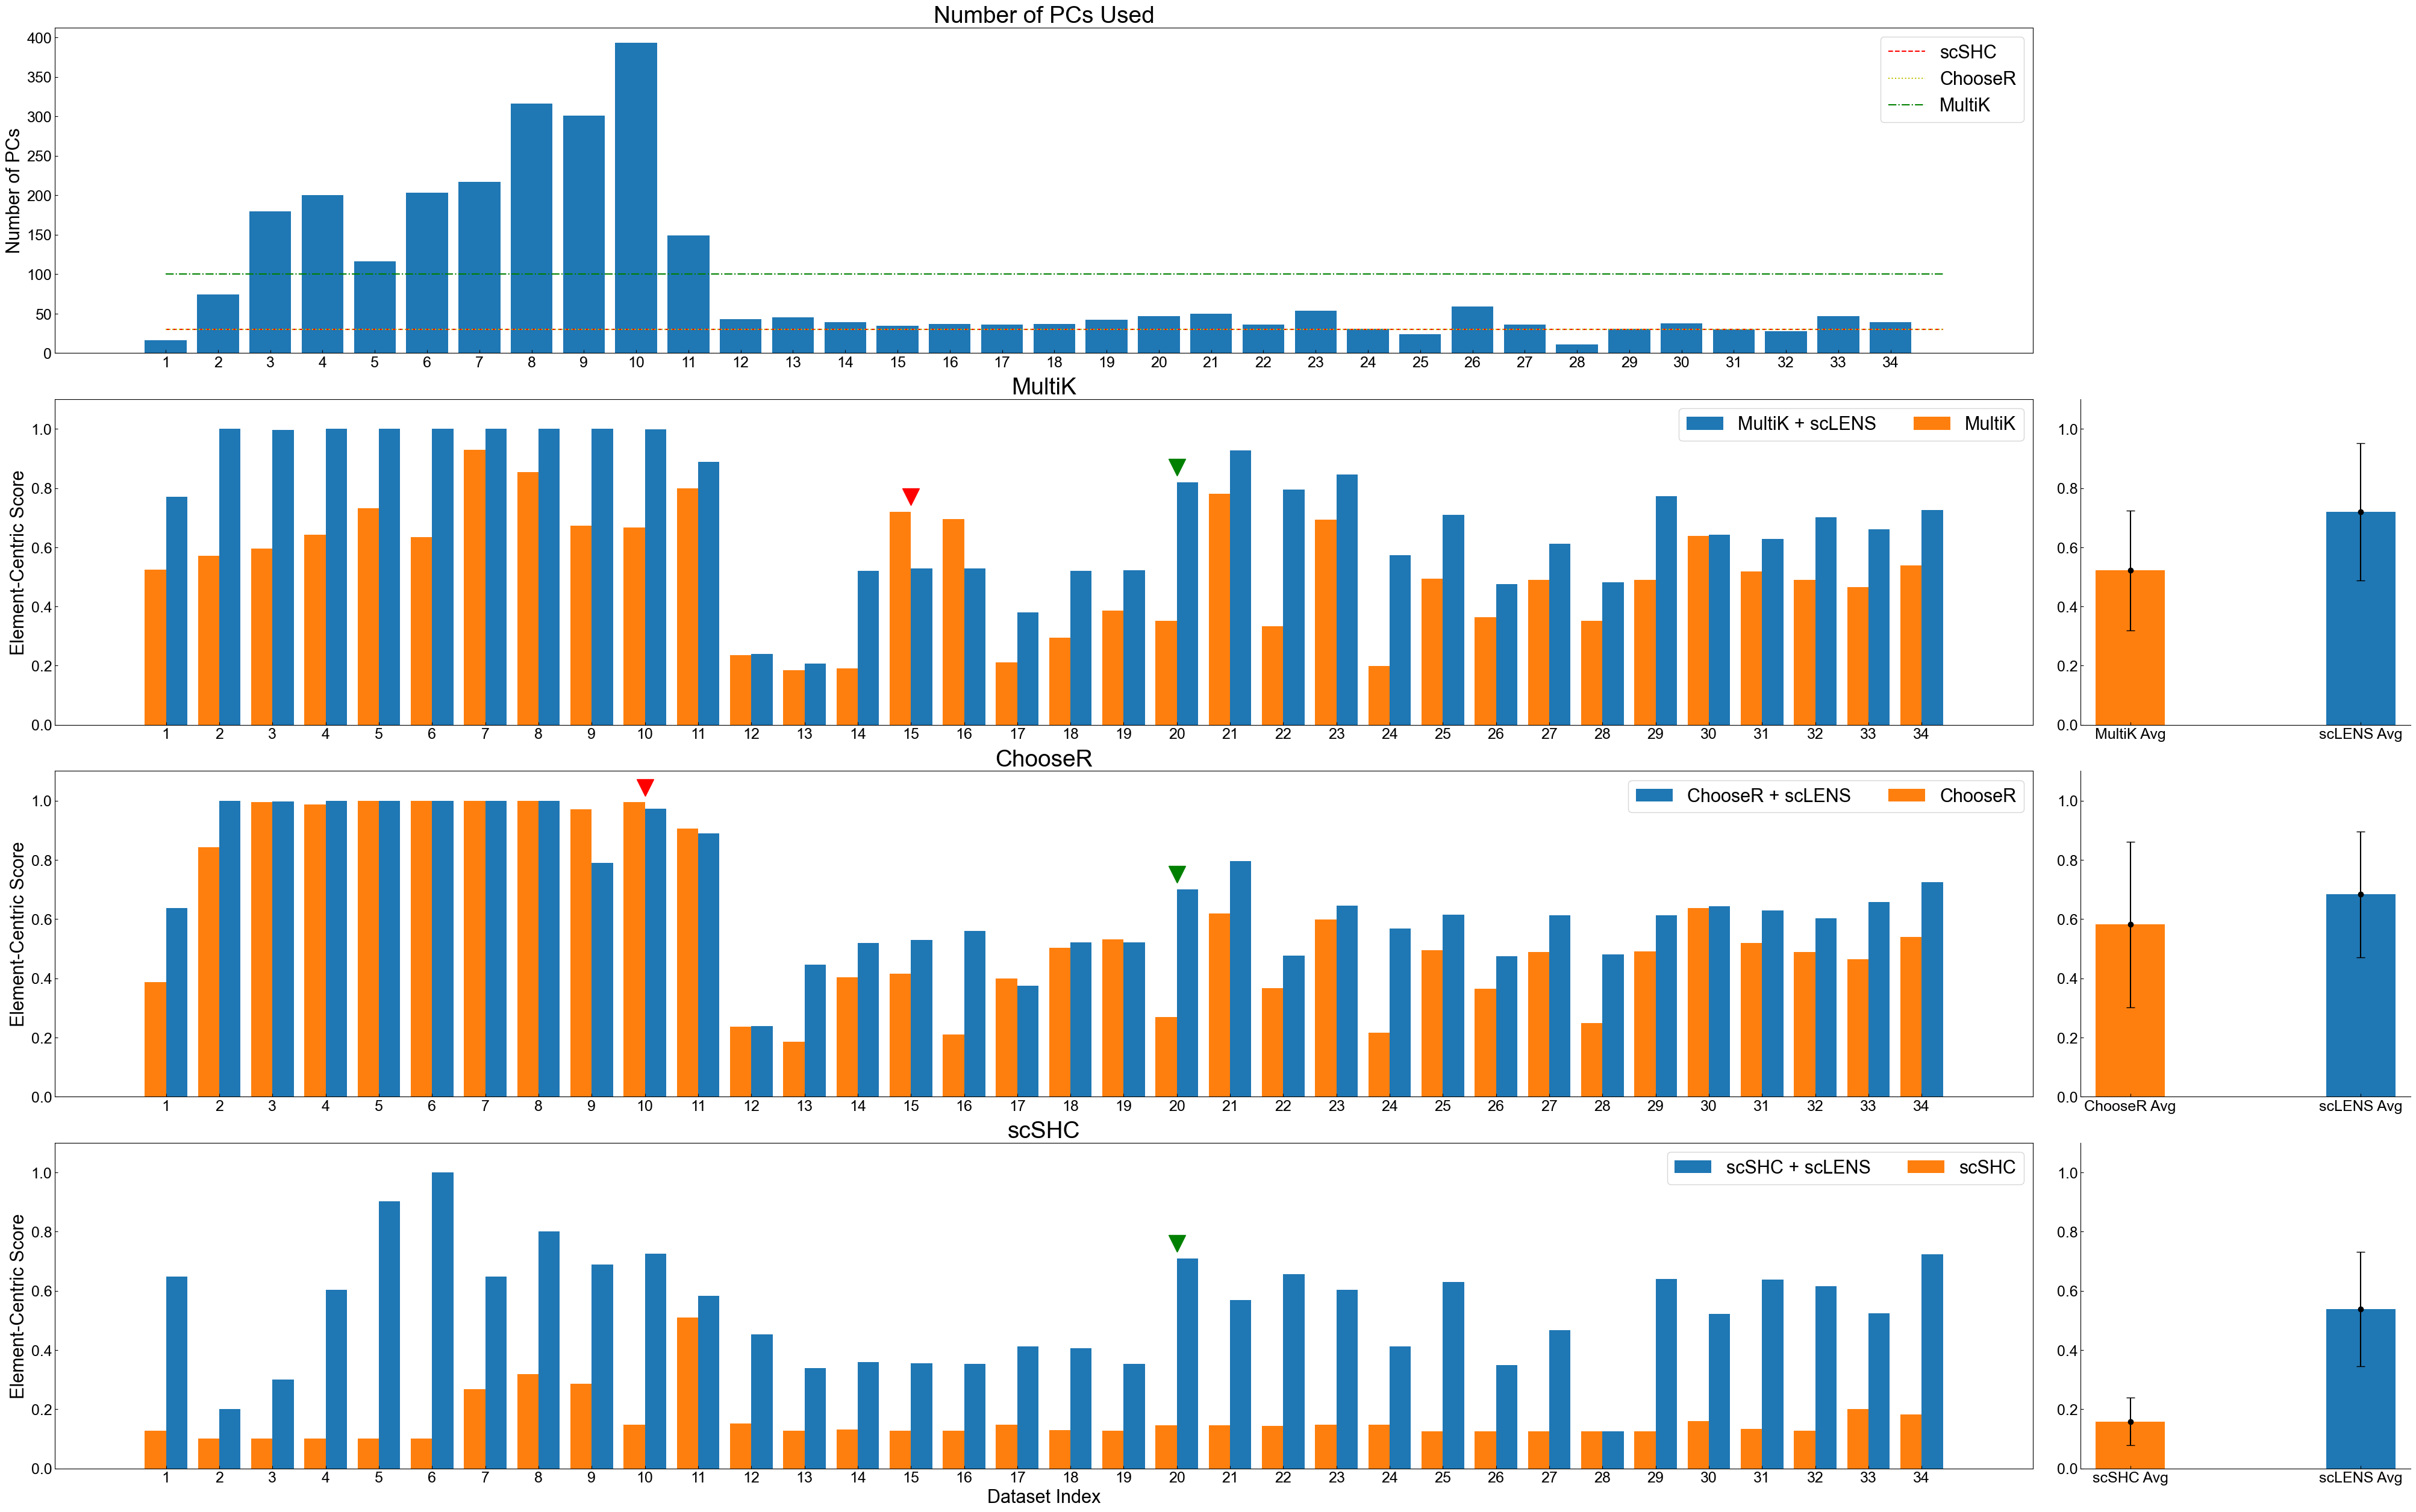

In [24]:
fig, axs = plt.subplots(4, 2, figsize=(40, 25), layout='constrained', width_ratios=(6, 1))
pivot = np.arange(len(signal_counts))

# NUMBER OF PCs USED
ax = axs[0, 0]
ax.tick_params(axis='both', direction='in', labelsize=18)

ax.bar(pivot, signal_counts['n_signal'])

ax.xaxis.set_ticks(np.arange(len(signal_counts)))
ax.set_xticklabels(np.arange(1, len(signal_counts) + 1))
ax.set_ylabel('Number of PCs', fontsize=22)
ax.set_title('Number of PCs Used', fontsize=28)

ax.hlines(30, 0, len(signal_counts), linestyles='dashed', colors='r', label='scSHC')
ax.hlines(30, 0, len(signal_counts), linestyles='dotted', colors='y', label='ChooseR')
ax.hlines(100, 0, len(signal_counts), linestyles='dashdot', colors='g', label='MultiK')
ax.legend(fontsize=22)

# MULTIK SCORES
ax = axs[1, 0]
ax.tick_params(axis='both', direction='in', labelsize=18)

width = 0.4
ax.bar(pivot + width/2, scl_scores['MultiK_ECC'].values, width=width, label='MultiK + scLENS')
ax.bar(pivot - width/2, noscl_scores['MultiK_ECC'].values, width=width, label='MultiK')

ax.plot(19, scl_scores['MultiK_ECC'].values[19] + 0.05, 'gv', markersize=20)
ax.plot(14, noscl_scores['MultiK_ECC'].values[14] + 0.05, 'rv', markersize=20)

ax.set_ylim(0, 1.1)
ax.set_ylabel('Element-Centric Score', fontsize=22)
ax.set_title('MultiK', fontsize=28)
ax.set_xticks(pivot, np.arange(1, len(signal_counts) + 1))
ax.legend(loc='upper right', ncols=2, fontsize=22)

# CHOOSER SCORES
ax = axs[2, 0]
ax.tick_params(axis='both', direction='in', labelsize=18)

width = 0.4
ax.bar(pivot + width/2, scl_scores['ChooseR_ECC'].values, width=width, label='ChooseR + scLENS')
ax.bar(pivot - width/2, noscl_scores['ChooseR_ECC'].values, width=width, label='ChooseR')

ax.plot(19, scl_scores['ChooseR_ECC'].values[19] + 0.05, 'gv', markersize=20)
ax.plot(9, noscl_scores['ChooseR_ECC'].values[9] + 0.05, 'rv', markersize=20)

ax.set_ylim(0, 1.1)
ax.set_ylabel('Element-Centric Score', fontsize=22)
ax.set_title('ChooseR', fontsize=28)
ax.set_xticks(pivot, np.arange(1, len(signal_counts) + 1))
ax.legend(loc='upper right', ncols=2, fontsize=22)

# SCSHC SCORES
ax = axs[3, 0]
ax.tick_params(axis='both', direction='in', labelsize=18)

width = 0.4
ax.bar(pivot + width/2, scl_scores['scSHC_ECC'].values, width=width, label='scSHC + scLENS')
ax.bar(pivot - width/2, noscl_scores['scSHC_ECC'].values, width=width, label='scSHC')

ax.plot(19, scl_scores['scSHC_ECC'].values[19] + 0.05, 'gv', markersize=20)

ax.set_ylim(0, 1.1)
ax.set_ylabel('Element-Centric Score', fontsize=22)
ax.set_title('scSHC', fontsize=28)
ax.set_xticks(pivot, np.arange(1, len(signal_counts) + 1))
ax.set_xlabel('Dataset Index', fontsize=22)
ax.legend(loc='upper right', ncols=2, fontsize=22)

# MULTIK MEAN
ax = axs[1, 1]
ax.tick_params(axis='both', direction='in', labelsize=18)
ax.spines[['right', 'top']].set_visible(False)

ax.bar(1, scl_scores['MultiK_ECC'].mean(), width=0.3)
ax.errorbar(1, scl_scores['MultiK_ECC'].mean(), yerr=scl_scores['MultiK_ECC'].std(), fmt='o', color='k', capsize=5)
ax.bar(0, noscl_scores['MultiK_ECC'].mean(), width=0.3)
ax.errorbar(0, noscl_scores['MultiK_ECC'].mean(), yerr=noscl_scores['MultiK_ECC'].std(), fmt='o', color='k', capsize=5)

# ax.set_title('MultiK Mean', fontsize=28)
ax.set_ylim(0, 1.1)
ax.set_xticks([0, 1], ['MultiK Avg', 'scLENS Avg'], fontsize=18)

# CHOOSER MEAN
ax = axs[2, 1]
ax.tick_params(axis='both', direction='in', labelsize=18)
ax.spines[['right', 'top']].set_visible(False)

ax.bar(1, scl_scores['ChooseR_ECC'].mean(), width=0.3)
ax.errorbar(1, scl_scores['ChooseR_ECC'].mean(), yerr=scl_scores['ChooseR_ECC'].std(), fmt='o', color='k', capsize=5)
ax.bar(0, noscl_scores['ChooseR_ECC'].mean(), width=0.3)
ax.errorbar(0, noscl_scores['ChooseR_ECC'].mean(), yerr=noscl_scores['ChooseR_ECC'].std(), fmt='o', color='k', capsize=5)

# ax.set_title('ChooseR Mean', fontsize=28)
ax.set_ylim(0, 1.1)
ax.set_xticks([0, 1], ['ChooseR Avg', 'scLENS Avg'], fontsize=18)

# SCSHC MEAN
ax = axs[3, 1]
ax.tick_params(axis='both', direction='in', labelsize=18)
ax.spines[['right', 'top']].set_visible(False)

ax.bar(1, scl_scores['scSHC_ECC'].mean(), width=0.3)
ax.errorbar(1, scl_scores['scSHC_ECC'].mean(), yerr=scl_scores['scSHC_ECC'].std(), fmt='o', color='k', capsize=5)
ax.bar(0, noscl_scores['scSHC_ECC'].mean(), width=0.3)
ax.errorbar(0, noscl_scores['scSHC_ECC'].mean(), yerr=noscl_scores['scSHC_ECC'].std(), fmt='o', color='k', capsize=5)

# ax.set_title('scSHC Mean', fontsize=28)
ax.set_ylim(0, 1.1)
ax.set_xticks([0, 1], ['scSHC Avg', 'scLENS Avg'], fontsize=18)

# Delete top right figure
ax = axs[0, 1]
ax.axis('off')

plt.show()

# Mappings

## Success

In [25]:
scl_scores.index[23]

'data/sim_Tcell/6083-4496.csv.gz'

In [26]:
file = scl_scores.index[23][5:]
file = file.replace('/', '-')
scl_mapping = pd.read_csv('../Mappings/sclens/' + file, index_col=0)
scl_mapping

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,52.762616,125.543447,148.594612,531.644566,-14.036451,82.896828,-233.949723,676.926945,-647.406519,886.717054,...,-1075.548322,1278.062733,-557.054605,393.700936,-392.925220,573.694084,2093.533800,-1138.979437,2898.850537,5159.990107
1,-146.994534,-310.124197,280.160397,-192.227402,-16.909023,7.583889,360.490798,-49.975290,-165.137438,-212.178209,...,301.593646,20.797126,273.096082,258.215229,-212.981123,534.815198,-1272.177209,-65.023887,-309.418706,-46.287888
2,43.579847,-299.684354,-611.134074,112.726752,-192.161433,184.781742,-64.273506,279.793336,-241.418123,-154.001934,...,723.111612,-341.487194,-1002.158343,641.942206,262.898562,1196.147185,1232.625382,-108.089976,279.016613,-1688.605689
3,154.092023,114.327419,539.241078,769.674867,-222.845375,433.588995,309.078395,226.899882,-197.130272,-40.433071,...,552.475614,-535.754714,195.170259,-906.572690,-641.374000,-273.459068,-328.719801,756.544971,3.409366,-6278.030760
4,395.479416,644.609709,761.179553,-125.724239,109.711160,27.955092,176.641162,442.077241,-685.030559,-151.200797,...,1446.685450,1021.207870,-818.977273,-1099.339377,1048.989371,8.334130,393.190208,177.160239,-1399.642744,12071.208421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2969,-41.236086,228.496668,716.634085,331.249960,501.884530,-348.702864,-37.712571,-558.974020,-404.828509,82.677991,...,721.074597,909.747706,1089.447089,1934.645480,-1197.570515,-351.789669,609.161112,-760.520825,1642.927372,3120.277252
2970,563.781947,495.233695,-230.116648,-30.034802,345.039828,606.020605,-582.090928,-535.275546,89.478375,-109.663567,...,29.074974,-731.388380,-762.815541,134.931972,-1105.583214,-326.713070,943.148990,74.811029,4658.627843,1762.988993
2971,-160.178534,-215.826341,-114.207589,447.379108,470.577961,211.121637,-255.726157,405.335209,-385.343189,122.054237,...,-472.653552,142.936307,-1163.329658,-773.603498,-1049.475584,-749.718930,208.240898,-1241.910870,3274.627814,-979.180364
2972,190.817478,-81.016391,45.339886,45.703613,143.071502,-156.339156,202.938846,-1161.014688,-183.791889,-119.795212,...,838.663474,-376.553253,-261.528181,557.297519,-122.454621,-574.836588,-2301.365842,-1251.624807,-1149.618586,1500.184207


In [33]:
multik_succ = pd.read_csv("success_multik.csv", index_col=0)
multik_succ

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_21,PC_22,PC_23,PC_24,PC_25,PC_26,PC_27,PC_28,PC_29,PC_30
Cell_1,-7.730633,-6.655785,-3.462072,4.312602,-0.269612,2.692246,4.168512,-1.119051,-5.554695,-0.111584,...,-2.580230,-0.692648,-1.255674,-2.350693,0.520867,1.474929,0.757451,0.752705,-2.890113,1.325851
Cell_2,6.091362,4.775161,-4.532789,-1.998780,-3.487634,0.246449,-1.703031,0.513426,1.683597,1.440993,...,2.660206,-2.039878,-0.842222,0.157618,-0.257941,0.385050,-0.654740,0.209748,0.169480,3.647004
Cell_3,2.368752,-1.221626,2.394653,4.182735,-0.787763,0.044385,-0.778300,6.360167,-1.146651,-0.701855,...,0.778105,1.184264,0.898648,2.595931,-2.174731,-0.940131,-0.685038,-0.227609,0.712285,0.483732
Cell_4,5.507588,-1.172826,3.607059,-0.268839,-0.324011,-0.560174,0.784488,-3.006524,3.074005,-0.171894,...,-0.719995,1.772393,0.512786,-1.709796,0.212963,3.302113,0.887782,-0.860026,3.196793,1.177454
Cell_5,-14.421012,3.768870,-2.763908,-0.905661,2.281027,2.516313,3.046956,4.868410,2.017079,1.047112,...,1.644607,0.622095,-0.631863,-0.051437,2.275934,-2.178571,3.615675,-1.533772,-3.399149,0.702546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell_2970,-5.745065,-5.919037,0.385273,4.519684,0.930842,-4.814336,-1.880033,0.692139,0.706423,1.262461,...,3.045936,-1.738348,1.558594,-3.052710,-0.354401,-1.561308,0.965430,0.371585,2.139928,1.019766
Cell_2971,1.242585,-5.493099,-4.447471,0.602513,-1.430979,-4.787263,4.398543,-0.816712,-0.407740,-1.096104,...,1.275133,2.760794,-1.265588,-1.191226,0.450550,-0.910016,0.214612,-0.324073,0.092812,2.377197
Cell_2972,1.684837,-6.478548,-3.822842,-0.164837,-1.578508,-2.661060,3.729003,-1.669214,-1.381220,-0.127264,...,0.680590,-0.946549,-0.506317,-0.162436,-1.510986,2.241038,0.077171,1.897905,1.013573,0.690592
Cell_2973,0.507217,1.688871,-3.977456,-1.978834,-1.714561,-2.826589,-2.984495,2.370248,2.316143,2.285943,...,0.960240,-2.146380,-0.436382,-1.275635,0.899864,2.500347,-0.830052,-3.122704,-0.253781,-0.469884


In [34]:
chooser_succ = pd.read_csv("success_chooser.csv", index_col=0)
chooser_succ

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99,PC_100
Cell_1,7.126217,12.067284,9.827185,2.170014,8.318866,-3.517474,-4.920087,-2.857032,1.118934,4.843530,...,-0.347072,-2.966962,-4.425832,3.510830,1.912671,-1.604699,-1.027780,-2.560867,-1.268002,-1.120352
Cell_2,-2.244919,0.214849,-0.857053,1.045408,-3.924325,-0.185789,-0.147130,0.753987,-0.859279,-0.255579,...,-0.256243,-0.761064,0.898850,-0.357283,-1.702153,0.680008,-0.453258,-1.685171,1.145314,0.327970
Cell_3,-4.182685,0.484785,4.621278,3.042148,0.796341,-0.643210,-3.777980,-5.489612,0.144417,-4.644628,...,-0.850134,-0.336611,0.805557,1.298626,-0.777148,1.605377,0.091956,-2.201055,1.443720,3.335400
Cell_4,-10.911779,-3.051678,-2.631716,0.012268,1.383407,-2.390244,4.234161,2.645393,-1.108544,1.097143,...,-0.717968,2.457712,0.128821,0.384881,2.118598,0.628312,-1.047940,-1.106896,0.455140,-2.874997
Cell_5,25.115382,-0.329252,-3.064291,4.861140,2.627450,7.543884,4.355413,-4.001411,3.300956,-8.379254,...,-1.101397,-1.158794,-1.100215,0.974656,4.565404,-4.294069,-1.599181,-3.370917,0.376607,2.088052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell_2970,8.400931,8.959898,4.535257,-8.456670,-0.021780,-0.947270,-1.031146,2.982884,4.230479,-14.338770,...,-0.109551,6.377010,1.325081,2.591568,0.905297,3.713061,6.618696,-0.175487,-1.814610,-5.069774
Cell_2971,-2.201081,12.910311,4.226171,-5.278886,2.578209,-3.773649,4.602843,-3.261499,1.494663,0.652987,...,-1.762943,-4.238992,2.346944,0.630095,0.862890,-1.298864,0.028721,3.107951,0.336755,3.794317
Cell_2972,-5.980839,8.417548,4.099851,-4.704823,1.269403,-0.602410,6.657827,-1.712443,0.734384,1.485633,...,-0.394021,0.385460,1.301001,-0.280928,-3.387872,-1.201562,-0.952677,0.548892,0.211200,-2.413007
Cell_2973,0.776555,-0.775083,-1.144993,-1.642430,-8.158079,2.080701,1.657262,-1.172314,2.515792,-2.096285,...,-2.313769,-0.367832,-1.669153,-0.778262,0.009723,-1.460831,-0.433960,0.291046,-1.643282,-0.075240


In [35]:
scshc_succ = pd.read_csv("scshc_success.csv", index_col=0)
scshc_succ

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
1,14.771498,17.272800,-9.217831,5.147220,-4.311189,-5.387458,-2.414486,6.882912,4.516534,-5.482065,...,5.986963,4.523925,-1.835168,3.835370,1.158365,-5.679799,-0.673879,-4.421139,0.477936,-2.783654
2,0.844582,-0.663949,-0.008233,-2.226150,1.290015,-3.469924,0.841060,0.270892,-0.997807,1.007015,...,2.026226,-0.588860,1.114916,-0.295119,0.938728,-0.326437,2.277719,-1.763061,-0.504631,0.047907
3,0.497380,3.024377,-3.743508,1.863262,-7.227810,2.485353,4.506304,-2.921495,-1.796172,5.275686,...,-3.559037,-1.760368,-6.774118,0.061550,-1.793542,-1.815438,3.105073,0.811940,-0.802226,-0.128762
4,-13.977452,2.365160,4.279063,1.790200,-1.242066,1.115361,-3.775786,0.967214,0.476046,-1.128547,...,-3.417140,1.018509,1.820139,0.712574,-0.975740,-0.935843,0.224311,-0.588791,-3.945569,2.012499
5,24.094015,-5.703713,2.730041,-2.358983,-3.225566,7.751379,3.239796,3.588081,0.451446,2.166926,...,2.981596,1.104614,2.701815,2.274318,0.656265,-1.716045,-1.834078,0.081388,-0.091144,1.543302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2970,18.512304,6.477188,-9.910331,2.224987,8.133464,2.839975,18.535305,-10.728115,6.135142,2.097884,...,1.670972,6.116028,-8.388032,1.675207,1.749466,-7.122597,0.193472,-1.601266,-5.304518,5.508651
2971,7.678917,14.214505,-4.200759,1.233395,-1.746398,1.698822,-2.697461,-4.580537,4.226126,0.449849,...,0.296888,-0.637945,-3.586997,1.691023,2.639870,2.314263,0.091054,0.261644,0.132573,-1.315611
2972,-3.868860,11.400534,-6.934748,0.807544,2.519198,7.519460,-3.769342,4.051116,5.018997,-3.398920,...,-2.785758,0.029756,-2.211427,0.343665,1.383126,-2.039485,0.364509,2.267935,1.592105,-1.349450
2973,2.753415,-6.192848,0.408475,-8.049283,4.733095,3.214171,2.252164,-1.718666,2.265218,2.016463,...,-1.924529,3.578146,1.377943,-0.266284,-2.191297,1.806531,1.304401,-1.888462,0.564660,-1.934799


In [36]:
import umap
import umap.plot

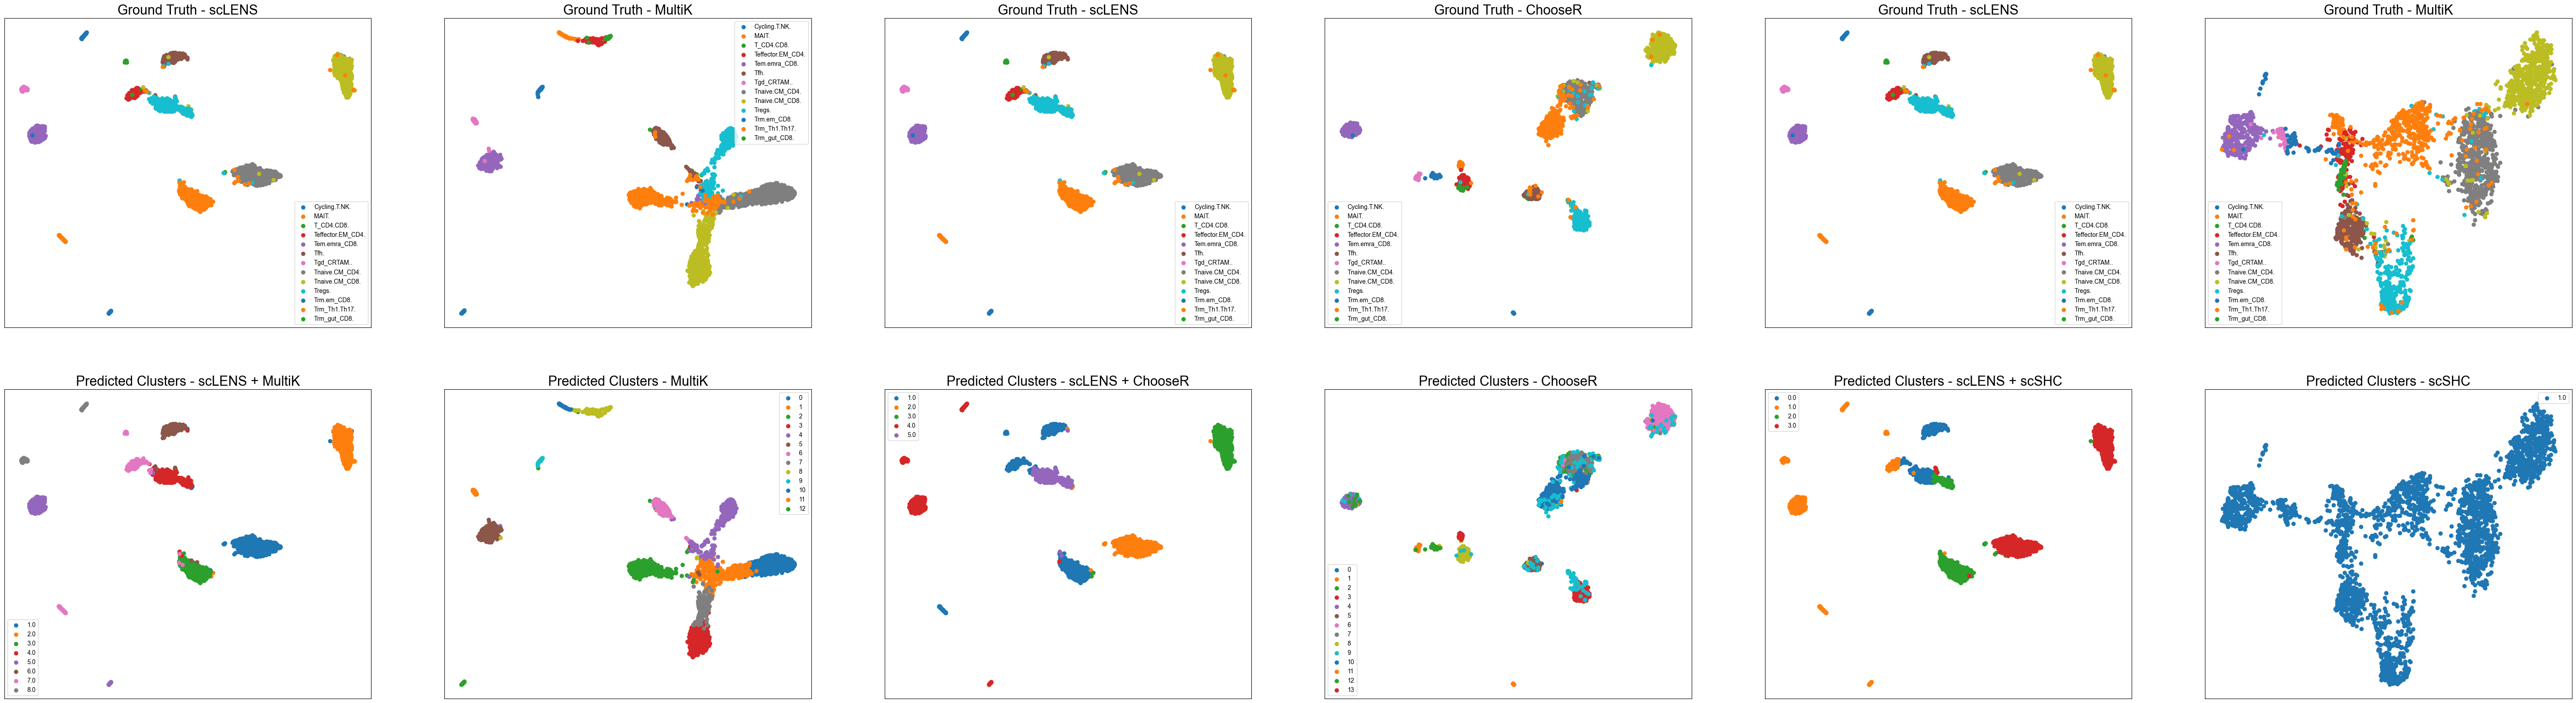

In [42]:
fig, axs = plt.subplots(2, 6, figsize=(75, 20))

# TRUE LABEL - SCLENS
ax = axs[0, 0]
ax.tick_params(axis='both', direction='in')
ax.set_yticks([])
ax.set_xticks([])

label = pd.read_csv('data/sim_Tcell/6083-4496.csv.gz')['cell']

scl_umap = umap.UMAP(metric='cosine').fit(scl_mapping)

for l in np.unique(label):
    idx = np.where(label == l)
    ax.scatter(scl_umap.embedding_[idx, 0], scl_umap.embedding_[idx, 1], label=l)

ax.set_title("Ground Truth - scLENS", fontsize=22)
ax.legend()

# TRUE LABEL - SCLENS
ax = axs[0, 2]
ax.tick_params(axis='both', direction='in')
ax.set_yticks([])
ax.set_xticks([])

for l in np.unique(label):
    idx = np.where(label == l)
    ax.scatter(scl_umap.embedding_[idx, 0], scl_umap.embedding_[idx, 1], label=l)

ax.set_title("Ground Truth - scLENS", fontsize=22)
ax.legend()

# TRUE LABEL - SCLENS
ax = axs[0, 4]
ax.tick_params(axis='both', direction='in')
ax.set_yticks([])
ax.set_xticks([])

for l in np.unique(label):
    idx = np.where(label == l)
    ax.scatter(scl_umap.embedding_[idx, 0], scl_umap.embedding_[idx, 1], label=l)

ax.set_title("Ground Truth - scLENS", fontsize=22)
ax.legend()

# TRUE LABEL - MULTIK
ax = axs[0, 1]
ax.tick_params(axis='both', direction='in')
ax.set_yticks([])
ax.set_xticks([])

multik_umap = umap.UMAP(metric='cosine').fit(multik_succ)

for l in np.unique(label):
    idx = np.where(label == l)
    ax.scatter(multik_umap.embedding_[idx, 0], multik_umap.embedding_[idx, 1], label=l)

ax.set_title("Ground Truth - MultiK", fontsize=22)
ax.legend()

# TRUE LABEL - CHOOSER
ax = axs[0, 3]
ax.tick_params(axis='both', direction='in')
ax.set_yticks([])
ax.set_xticks([])

chooser_umap = umap.UMAP(metric='cosine').fit(chooser_succ)

for l in np.unique(label):
    idx = np.where(label == l)
    ax.scatter(chooser_umap.embedding_[idx, 0], chooser_umap.embedding_[idx, 1], label=l)

ax.set_title("Ground Truth - ChooseR", fontsize=22)
ax.legend()

# TRUE LABEL - MULTIK
ax = axs[0, 5]
ax.tick_params(axis='both', direction='in')
ax.set_yticks([])
ax.set_xticks([])

scshc_umap = umap.UMAP(metric='cosine').fit(scshc_succ)

for l in np.unique(label):
    idx = np.where(label == l)
    ax.scatter(scshc_umap.embedding_[idx, 0], scshc_umap.embedding_[idx, 1], label=l)

ax.set_title("Ground Truth - MultiK", fontsize=22)
ax.legend()

# PREDICTED - SCLENS MULTIK
ax = axs[1, 0]
ax.tick_params(axis='both', direction='in')
ax.set_yticks([])
ax.set_xticks([])

label = pd.read_csv('success_cls_multik_scl.csv')['cluster']

for l in np.unique(label):
    idx = np.where(label == l)
    ax.scatter(scl_umap.embedding_[idx, 0], scl_umap.embedding_[idx, 1], label=l)

ax.set_title("Predicted Clusters - scLENS + MultiK", fontsize=22)
ax.legend()

# PREDICTED - MULTIK
ax = axs[1, 1]
ax.tick_params(axis='both', direction='in')
ax.set_yticks([])
ax.set_xticks([])

label = pd.read_csv('../data_sim_Tcell_6083-4496.csv')['K_13']

for l in np.unique(label):
    idx = np.where(label == l)
    ax.scatter(multik_umap.embedding_[idx, 0], multik_umap.embedding_[idx, 1], label=l)

ax.set_title("Predicted Clusters - MultiK", fontsize=22)
ax.legend()

# PREDICTED - SCLENS CHOOSER
ax = axs[1, 2]
ax.tick_params(axis='both', direction='in')
ax.set_yticks([])
ax.set_xticks([])

label = pd.read_csv('success_cls_chooser_scl.csv')['cluster']

for l in np.unique(label):
    idx = np.where(label == l)
    ax.scatter(scl_umap.embedding_[idx, 0], scl_umap.embedding_[idx, 1], label=l)

ax.set_title("Predicted Clusters - scLENS + ChooseR", fontsize=22)
ax.legend()

# PREDICTED - MULTIK
ax = axs[1, 3]
ax.tick_params(axis='both', direction='in')
ax.set_yticks([])
ax.set_xticks([])

label = pd.read_csv('success_cls_chooser.csv')['x']

for l in np.unique(label):
    idx = np.where(label == l)
    ax.scatter(chooser_umap.embedding_[idx, 0], chooser_umap.embedding_[idx, 1], label=l)

ax.set_title("Predicted Clusters - ChooseR", fontsize=22)
ax.legend()

# PREDICTED - SCLENS SCSHC
ax = axs[1, 4]
ax.tick_params(axis='both', direction='in')
ax.set_yticks([])
ax.set_xticks([])

label = pd.read_csv('success_cls_scshc_scl.csv')['cluster']

for l in np.unique(label):
    idx = np.where(label == l)
    ax.scatter(scl_umap.embedding_[idx, 0], scl_umap.embedding_[idx, 1], label=l)

ax.set_title("Predicted Clusters - scLENS + scSHC", fontsize=22)
ax.legend()

# PREDICTED - SCSHC
ax = axs[1, 5]
ax.tick_params(axis='both', direction='in')
ax.set_yticks([])
ax.set_xticks([])

label = np.ones(scshc_umap.embedding_.shape[0])

for l in np.unique(label):
    idx = np.where(label == l)
    ax.scatter(scshc_umap.embedding_[idx, 0], scshc_umap.embedding_[idx, 1], label=l)

ax.set_title("Predicted Clusters - scSHC", fontsize=22)
ax.legend()

plt.show()

## Fail - MultiK

In [63]:
scl_scores.index[14]

'data/sim_Tcell/3276-1042.csv.gz'

In [64]:
file = scl_scores.index[14][5:]
file = file.replace('/', '-')
scl_mapping = pd.read_csv('../Mappings/sclens/' + file, index_col=0)
scl_mapping

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,-57.463326,449.185230,-63.769314,541.610267,-249.570851,91.508955,-472.932785,-902.725027,555.916331,-205.809949,...,-25.446005,476.573805,-78.408176,580.311640,-657.090114,1219.102729,-264.618752,1448.298794,-3527.350568,2864.278689
1,-113.600261,-531.480166,177.306525,-144.301766,418.047873,32.485126,234.772814,-62.390555,461.136541,-19.418671,...,-500.617907,-228.141768,-67.653561,929.968348,562.579776,-1133.875853,-152.828362,-2010.571245,-1882.517191,-1474.242569
2,140.706158,-998.738367,1038.424852,57.069839,296.560063,-396.140607,1094.431106,1077.276330,391.804625,-158.376722,...,635.051228,-959.854392,163.658683,507.688940,-691.945728,2425.488717,-2657.178978,2538.175368,-2189.485606,-1606.632781
3,-395.363146,-515.767929,275.173423,312.141372,-94.578620,-234.101996,-390.663872,380.373388,696.588679,-577.354460,...,157.725521,45.769112,-63.766792,30.175587,-827.787089,-1217.220302,2440.758422,-2342.853152,-417.251288,-4390.801331
4,279.764371,-398.654102,379.916792,6.784935,-265.456244,-609.596616,516.059845,59.964704,-573.901346,-448.081317,...,699.660164,-218.293395,106.533667,-1142.076147,-1069.651839,287.578575,955.099039,-2732.725384,-1333.061576,-2769.582817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,-414.255021,-608.974112,421.185071,529.269276,117.746749,130.692559,-490.680181,-215.214179,-154.230794,297.309539,...,-147.910384,-731.394483,43.025304,-452.109367,255.714214,-772.061039,-2090.163530,-2846.671208,-2580.507315,2365.957925
2996,54.955275,-98.040136,437.481870,-817.357683,-79.517897,-360.608045,736.320507,150.307413,156.655859,-214.927715,...,562.840183,392.660831,-295.634286,406.520628,650.805437,-1178.060724,-327.024357,-1646.629790,-1720.459370,-570.658050
2997,39.555207,-228.664852,-847.630102,189.567682,1133.478987,671.436367,-266.566471,-524.536606,-544.797947,-334.358396,...,206.257373,1204.240456,465.107548,1457.460971,502.093373,1171.895852,1533.699554,-1170.394865,2870.182783,5401.309461
2998,-750.394230,-152.887702,42.106585,-59.846028,-478.743376,508.561854,827.606115,-263.753811,-898.672586,-380.781379,...,-520.809192,-366.339284,499.523234,699.355994,-1295.876702,1501.928069,671.477080,29.165571,-4168.944192,2609.288546


In [65]:
multik_mapping = pd.read_csv("fail_multik.csv", index_col=0)
multik_mapping

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_21,PC_22,PC_23,PC_24,PC_25,PC_26,PC_27,PC_28,PC_29,PC_30
Cell_1,0.308515,-5.936663,-3.392866,-2.922077,-2.550812,1.535430,-3.545481,-2.615286,-2.158836,-0.043094,...,-0.241664,-0.277769,1.000943,0.383347,0.374728,-0.755665,1.107515,0.647467,0.262690,-0.642495
Cell_2,4.526953,-1.377952,5.957932,0.592236,2.778449,-0.643833,3.003216,3.894932,4.406381,0.637615,...,2.088182,0.208540,-1.142429,4.738081,-1.068022,-0.297334,-0.107403,1.360070,-2.362497,5.038162
Cell_3,1.277292,-5.209685,-0.379836,-2.633965,-4.143446,2.437124,-3.514890,1.792310,0.232238,3.633080,...,-2.657097,-0.958596,-1.653132,0.658273,-0.774304,-0.584834,1.163127,0.377909,2.261938,-1.086770
Cell_4,6.208855,4.372489,3.001575,-1.057101,7.281118,7.039273,2.141538,-0.588107,-1.102854,1.810638,...,1.159197,0.149026,1.534865,-0.737226,0.154133,2.850526,-3.973528,2.406737,-1.082646,-3.098832
Cell_5,5.190558,2.608238,1.234863,-2.719331,1.720389,4.099287,-0.574470,-2.807245,-3.749434,2.034402,...,1.291356,-0.323053,3.979229,0.613897,-1.076684,-2.148018,-0.243667,-0.458170,-1.692342,2.146898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell_2996,1.011010,-4.080359,11.399041,2.491054,-0.266428,-1.718799,1.962996,4.197494,0.622677,-0.114146,...,-1.973872,-1.326318,1.559057,2.312016,1.245516,-0.871015,-5.938635,5.635105,-1.105448,2.740011
Cell_2997,2.606625,-1.661910,4.659454,2.344205,-1.107401,-1.717401,2.309614,1.787768,-0.320103,-2.483868,...,1.635140,1.014350,-1.270960,-2.420171,0.255948,0.325199,-0.788642,-0.197611,-2.206619,-0.512498
Cell_2998,-9.913294,7.288885,0.532844,-5.221764,-1.371466,-0.524233,-1.387738,2.134786,1.560142,-4.370777,...,0.187744,2.066075,-3.082464,-3.104052,-0.164781,-3.031603,0.229031,2.136100,1.680289,0.290026
Cell_2999,1.651468,-6.437536,-2.321912,-3.472599,-3.315324,2.609048,-4.331613,-0.849348,-0.730614,2.547144,...,-0.420627,0.088362,-2.272243,3.095674,-1.218497,1.077069,0.321154,0.234317,-0.659638,-2.234352


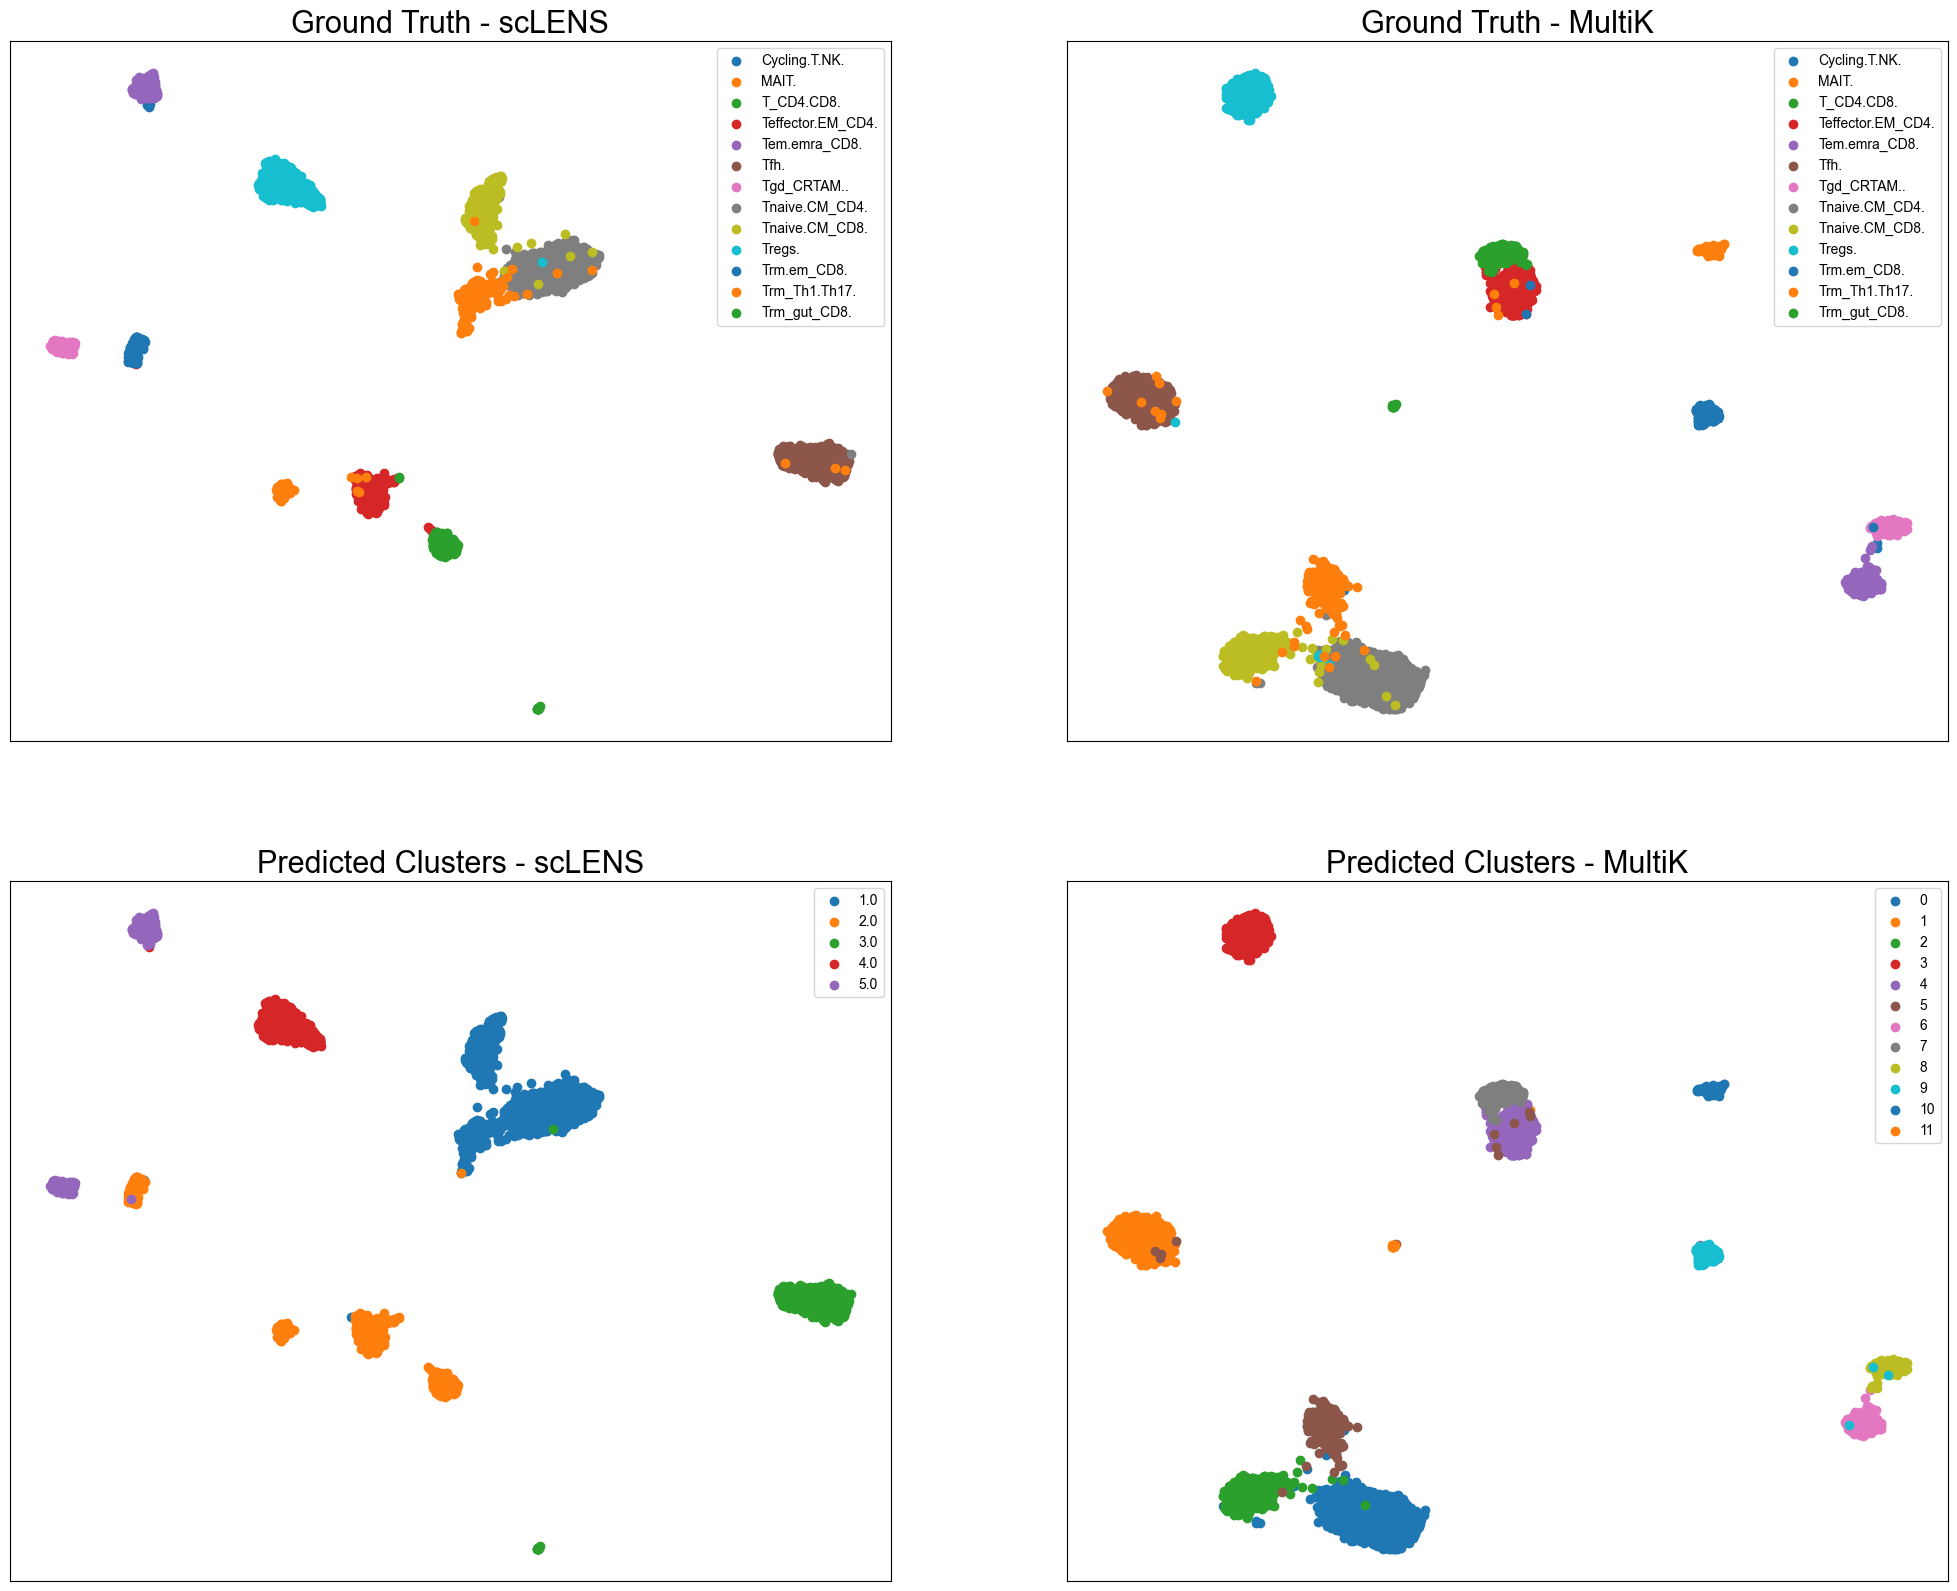

In [66]:
fig, axs = plt.subplots(2, 2, figsize=(25, 20))

# TRUE LABEL - SCLENS
ax = axs[0, 0]
ax.tick_params(axis='both', direction='in')
ax.set_yticks([])
ax.set_xticks([])

label = pd.read_csv('data/sim_Tcell/3276-1042.csv.gz')['cell']

scl_umap = umap.UMAP(metric='cosine').fit(scl_mapping)

for l in np.unique(label):
    idx = np.where(label == l)
    ax.scatter(scl_umap.embedding_[idx, 0], scl_umap.embedding_[idx, 1], label=l)

ax.set_title("Ground Truth - scLENS", fontsize=22)
ax.legend()

# TRUE LABEL - MULTIK
ax = axs[0, 1]
ax.tick_params(axis='both', direction='in')
ax.set_yticks([])
ax.set_xticks([])

multik_umap = umap.UMAP(metric='cosine').fit(multik_mapping)

for l in np.unique(label):
    idx = np.where(label == l)
    ax.scatter(multik_umap.embedding_[idx, 0], multik_umap.embedding_[idx, 1], label=l)

ax.set_title("Ground Truth - MultiK", fontsize=22)
ax.legend()

# PREDICTED - SCLENS
ax = axs[1, 0]
ax.tick_params(axis='both', direction='in')
ax.set_yticks([])
ax.set_xticks([])

label = pd.read_csv('fail_cls_multik_scl.csv')['cluster']

for l in np.unique(label):
    idx = np.where(label == l)
    ax.scatter(scl_umap.embedding_[idx, 0], scl_umap.embedding_[idx, 1], label=l)

ax.set_title("Predicted Clusters - scLENS", fontsize=22)
ax.legend()

# PREDICTED - MULTIK
ax = axs[1, 1]
ax.tick_params(axis='both', direction='in')
ax.set_yticks([])
ax.set_xticks([])

label = pd.read_csv('fail_cls_multik.csv')['K_12']

for l in np.unique(label):
    idx = np.where(label == l)
    ax.scatter(multik_umap.embedding_[idx, 0], multik_umap.embedding_[idx, 1], label=l)

ax.set_title("Predicted Clusters - MultiK", fontsize=22)
ax.legend()

plt.show()

## Fail - ChooseR

In [67]:
scl_scores.index[9]

'data/sim_T_muris/imbalanced/tmp_4.csv.gz'

In [68]:
file = scl_scores.index[9][5:]
file = file.replace('/', '-')
scl_mapping = pd.read_csv('../Mappings/sclens/' + file, index_col=0)
scl_mapping

,0,1,2,3,4,5,6,7,8,9,...,383,384,385,386,387,388,389,390,391,392
0,108.710178,-210.817402,567.668533,462.954596,-220.049961,83.381776,-145.737158,239.008748,-310.402545,231.893228,...,2200.718282,-553.438130,2170.519951,3148.577297,-2139.049506,124.907658,-21592.348274,19404.126325,-2150.424253,917.600341
1,374.811700,-72.274793,94.983500,-175.145860,-242.041249,-353.666256,-221.426825,-361.530133,-78.895225,-31.129470,...,-42.356572,-1763.504604,122.197854,2438.386184,-1729.246910,-1510.286497,-27809.367781,19244.959209,-3792.857348,-4717.824827
2,-222.791368,121.566065,287.097469,-156.284424,362.098856,111.337300,102.606845,-507.817424,-300.016001,50.322018,...,961.396754,-969.962875,1650.896404,762.765493,-1044.832309,-2735.467577,-19869.407112,15843.656898,-1593.366814,-4318.868043
3,289.416807,226.211398,-173.577641,36.046511,64.254480,-353.663568,185.084290,-74.740733,0.639918,15.515526,...,-916.417451,832.469269,-825.833756,229.239554,366.848952,-677.939289,-13604.696040,10671.202776,-1707.492470,-2073.032141
4,308.492707,428.870682,-20.061551,-500.971846,480.981029,85.516850,-259.349711,-7.204976,-204.357755,44.301412,...,2654.359017,-2253.610561,1693.665183,3540.104158,-1321.189231,602.112133,-25498.324952,19987.140179,-4667.581883,1300.124236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4308,298.316657,721.169055,-172.242505,350.598776,35.720647,86.013738,-282.526297,-180.656353,-310.359405,-289.160383,...,-3090.670306,11122.889091,4801.606297,-3442.721045,1670.867085,439.535060,1157.022915,-4764.604197,-15593.895710,-3035.061648
4309,233.274695,133.981176,615.818691,235.345570,-66.943970,575.492981,768.871427,223.567097,632.737955,-5.555628,...,-3310.008434,9697.719062,3189.476424,-2667.535789,705.600168,-503.316932,-2088.565913,-4235.524363,-13674.035846,-2944.273745
4310,427.256176,97.315885,2.126651,-41.335297,-175.631371,-448.785586,-206.309927,344.839644,459.302996,194.181550,...,-2750.802276,11510.424924,5639.951388,-3375.279667,650.440289,-413.695251,2105.854315,-5471.157317,-17557.933183,-1449.076232
4311,351.268045,-98.719506,-414.453004,-116.981588,-123.225119,-391.719416,-34.307479,455.975484,-219.704218,-437.738923,...,-1240.823814,11326.893852,6047.260058,-3238.928812,1269.772959,1225.812660,3016.798763,-5636.795324,-19116.302458,746.307082


In [69]:
chooser_mapping = pd.read_csv("fail_chooser.csv", index_col=0)
chooser_mapping

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99,PC_100
Cell_1,13.657001,23.676941,39.993709,12.611546,0.038735,-2.185644,-0.871114,-0.308751,-1.863814,-1.849139,...,4.998259,-2.797294,-0.561137,0.948620,3.033103,-1.812684,-2.495505,1.504954,5.516657,-3.040228
Cell_2,12.658537,23.100461,39.951559,15.172173,-0.561044,-4.680145,0.882934,-2.382818,1.166595,0.930878,...,3.412300,-1.268220,-1.968693,-0.821131,-0.069893,0.298956,0.143973,4.591570,0.451371,-0.079214
Cell_3,7.410961,14.323598,23.394352,6.510574,-1.872944,-2.857191,-1.702043,1.607886,-3.072532,1.930558,...,-0.188883,1.279388,-1.788634,1.464622,-1.065566,-0.875454,-0.171967,0.422121,1.343318,4.297209
Cell_4,7.138316,15.130203,22.866218,6.955398,-1.887667,-1.558931,1.507695,0.105633,3.122821,1.795696,...,2.531305,3.484266,-2.276695,2.358129,2.276381,-2.604476,-0.507231,1.102767,4.627228,2.368647
Cell_5,14.398980,21.433952,36.701164,11.838333,1.124253,-1.122081,-0.269405,-2.020801,-1.192295,-1.087409,...,0.116681,-1.695401,0.959830,1.356759,2.793230,-2.303603,0.210344,-2.148951,1.190276,-0.905437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell_4309,9.535603,-23.975167,1.562995,-2.082204,-1.718937,2.958284,-2.713396,47.817095,1.101662,0.672238,...,0.286458,-0.452278,0.121830,0.070188,0.723105,0.495168,-0.121317,-0.535847,0.444714,0.287907
Cell_4310,9.072433,-21.051184,2.545461,-1.945835,-1.879917,1.773790,-6.961324,38.796196,1.839000,-0.142778,...,0.305804,0.478097,0.983711,0.826794,-0.248360,-1.018645,-1.041109,-0.891630,-0.956067,-1.019416
Cell_4311,10.675516,-25.167441,1.386524,-1.749078,-2.223068,2.193251,-6.550432,51.589714,1.625113,1.019268,...,-0.747264,0.274066,0.951138,-0.545387,0.294877,0.665528,-0.836476,-0.340522,-0.205711,-1.003624
Cell_4312,11.131900,-23.849395,1.076417,-2.600540,-0.793083,2.699890,-2.356008,46.707843,0.886963,0.821597,...,0.914107,0.668213,0.223557,0.278451,0.216658,1.209814,2.155322,1.318767,0.812718,-0.024990


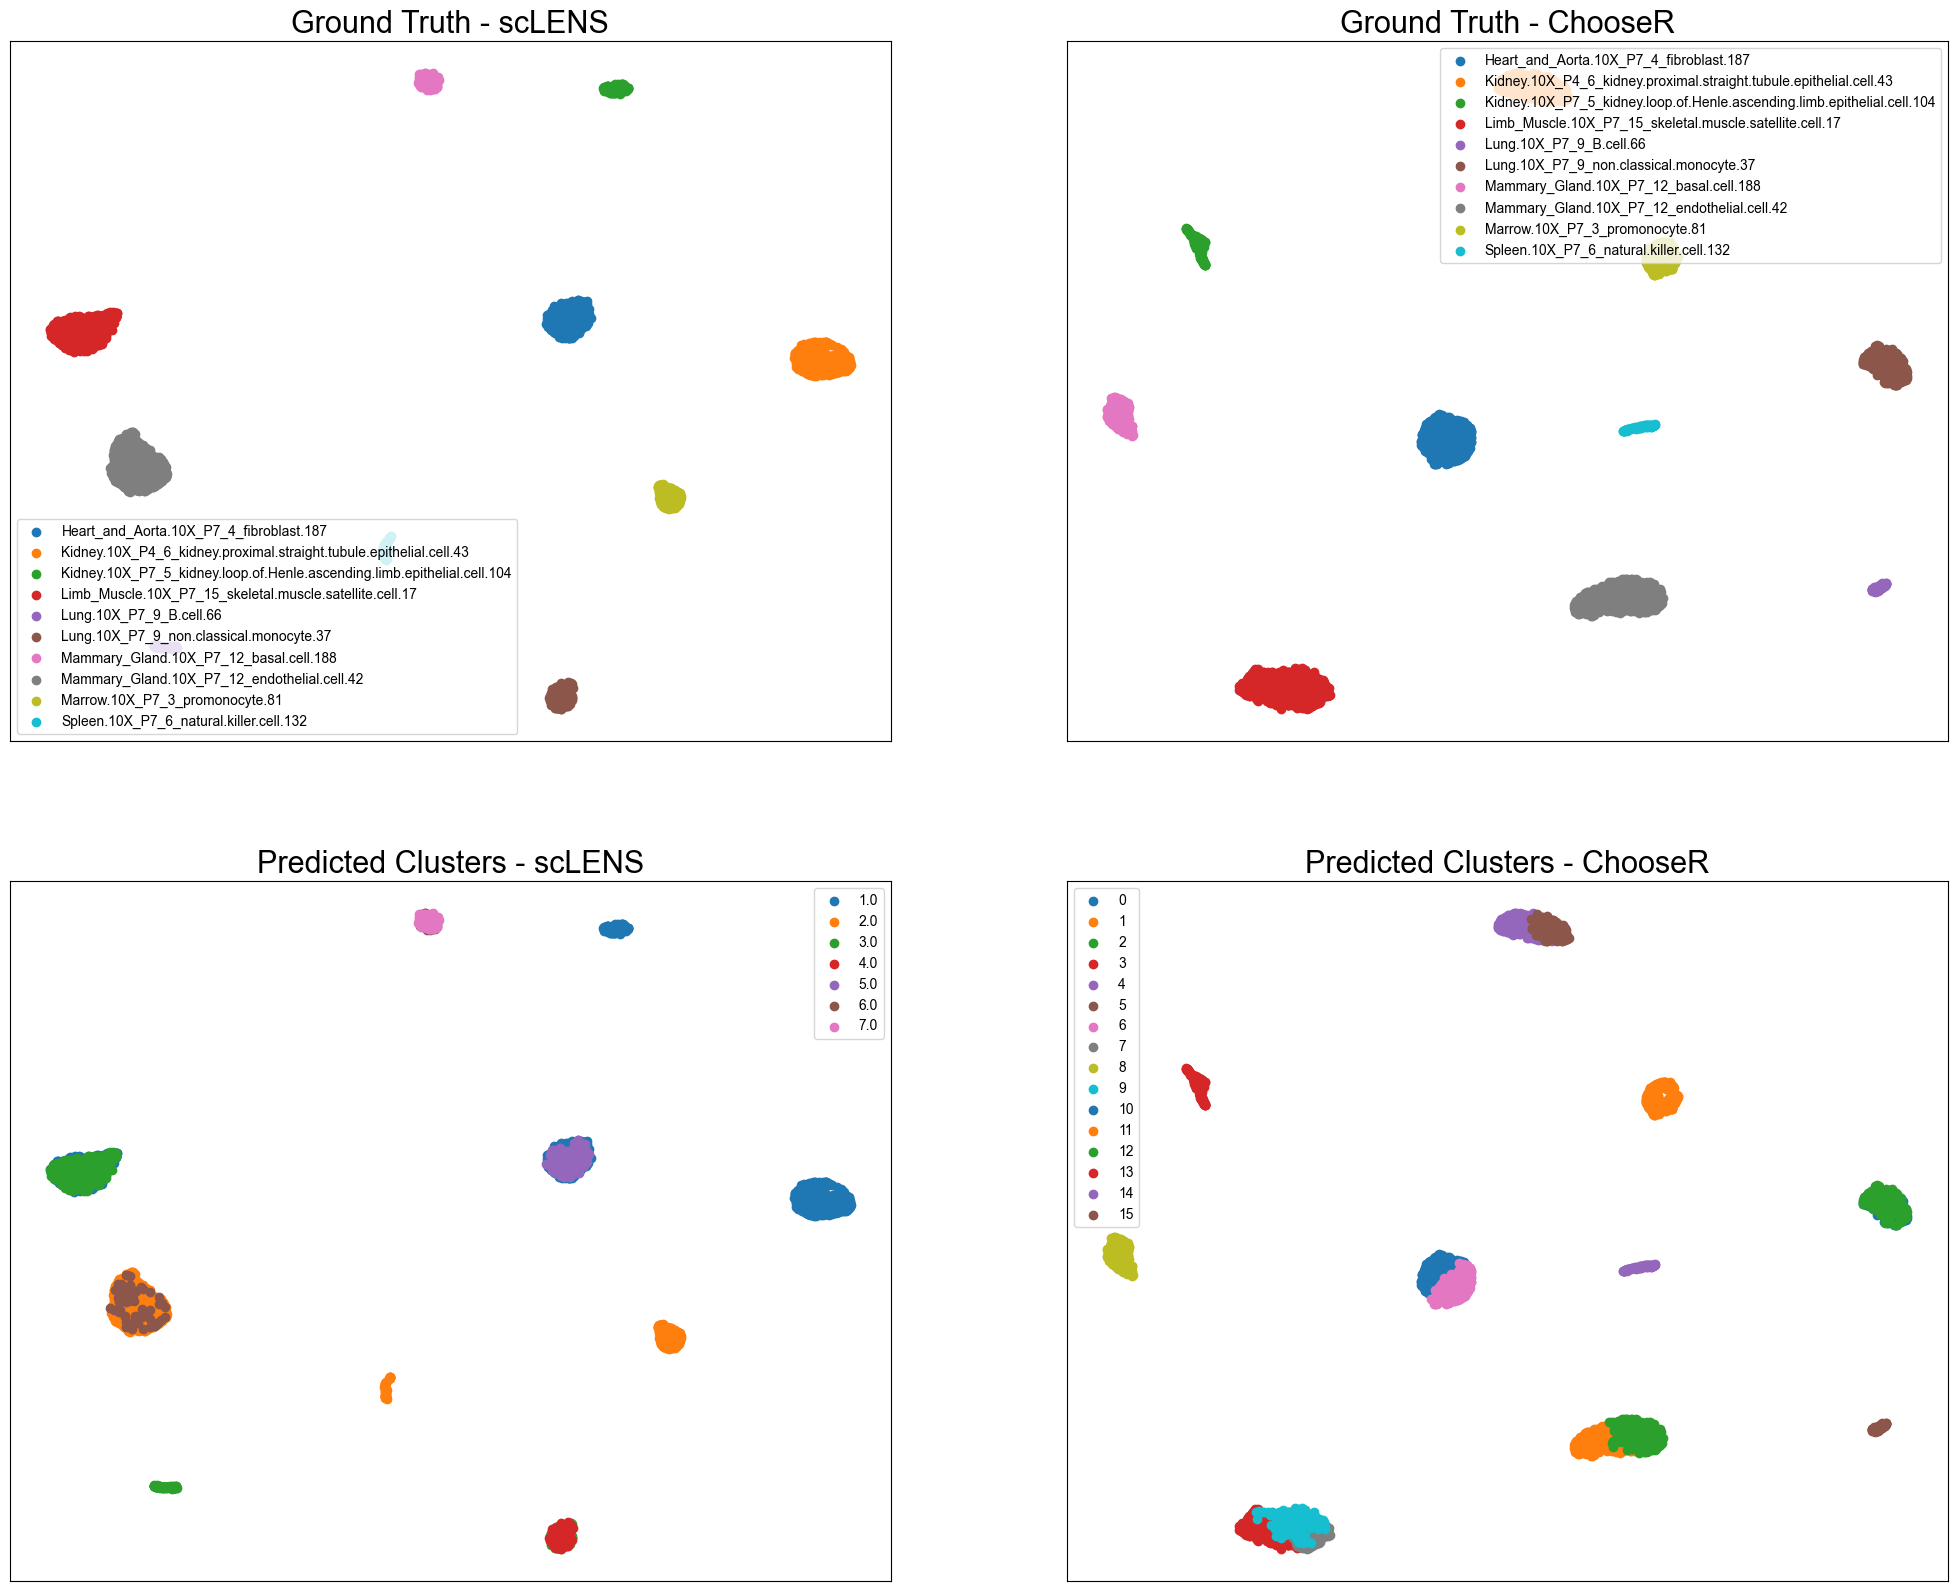

In [70]:
fig, axs = plt.subplots(2, 2, figsize=(25, 20))

# TRUE LABEL - SCLENS
ax = axs[0, 0]
ax.tick_params(axis='both', direction='in')
ax.set_yticks([])
ax.set_xticks([])

label = pd.read_csv('data/sim_T_muris/imbalanced/tmp_4.csv.gz')['cell']

scl_umap = umap.UMAP(metric='cosine').fit(scl_mapping)

for l in np.unique(label):
    idx = np.where(label == l)
    ax.scatter(scl_umap.embedding_[idx, 0], scl_umap.embedding_[idx, 1], label=l)

ax.set_title("Ground Truth - scLENS", fontsize=22)
ax.legend()

# TRUE LABEL - CHOOSER
ax = axs[0, 1]
ax.tick_params(axis='both', direction='in')
ax.set_yticks([])
ax.set_xticks([])

chooser_umap = umap.UMAP(metric='cosine').fit(chooser_mapping)

for l in np.unique(label):
    idx = np.where(label == l)
    ax.scatter(chooser_umap.embedding_[idx, 0], chooser_umap.embedding_[idx, 1], label=l)

ax.set_title("Ground Truth - ChooseR", fontsize=22)
ax.legend()

# PREDICTED - SCLENS
ax = axs[1, 0]
ax.tick_params(axis='both', direction='in')
ax.set_yticks([])
ax.set_xticks([])

label = pd.read_csv('fail_cls_chooser_scl.csv')['cluster']

for l in np.unique(label):
    idx = np.where(label == l)
    ax.scatter(scl_umap.embedding_[idx, 0], scl_umap.embedding_[idx, 1], label=l)

ax.set_title("Predicted Clusters - scLENS", fontsize=22)
ax.legend()

# PREDICTED - MULTIK
ax = axs[1, 1]
ax.tick_params(axis='both', direction='in')
ax.set_yticks([])
ax.set_xticks([])

label = pd.read_csv('fail_cls_chooser.csv')['x']

for l in np.unique(label):
    idx = np.where(label == l)
    ax.scatter(chooser_umap.embedding_[idx, 0], chooser_umap.embedding_[idx, 1], label=l)

ax.set_title("Predicted Clusters - ChooseR", fontsize=22)
ax.legend()

plt.show()

# Data Table

In [71]:
table = []
for file in scl_scores.index:
    df = pd.read_csv(file)
    label = df['cell']
    
    n_cell = df.shape[0]
    n_cls = len(np.unique(label))
    n_signal = signal_counts.loc[file]['n_signal']

    vcounts = label.value_counts()
    imb_ratio = max(vcounts) / min(vcounts)

    name = file.replace('.csv.gz', '')
    name = name.replace('data/', '')
    

    table.append([file, n_cell, n_cls, imb_ratio, n_signal])

table = pd.DataFrame(table, columns=['Dataset', '# Cells', '# CLusters', 'Imbalance Ratio', '# Signal Components'])
table

,Dataset,# Cells,# CLusters,Imbalance Ratio,# Signal Components
0,data/Z8eq.csv.gz,3994,8,1.507538,16
1,data/sim_T_muris/balanced/T_muris_1019.csv.gz,1019,10,1.208791,74
2,data/sim_T_muris/balanced/T_muris_2006.csv.gz,2006,10,1.189189,180
3,data/sim_T_muris/balanced/T_muris_3016.csv.gz,3016,10,1.187050,200
4,data/sim_T_muris/balanced/T_muris_3966.csv.gz,3966,10,1.192412,116
5,data/sim_T_muris/balanced/T_muris_5033.csv.gz,5033,10,1.174292,203
6,data/sim_T_muris/imbalanced/tmp_1.csv.gz,4827,7,18.333333,217
7,data/sim_T_muris/imbalanced/tmp_2.csv.gz,3501,6,17.526882,316
8,data/sim_T_muris/imbalanced/tmp_3.csv.gz,4244,7,12.695946,301
9,data/sim_T_muris/imbalanced/tmp_4.csv.gz,4313,10,8.280374,393


In [72]:
table.to_csv('data_table.csv')

# scLENS Extra

In [1]:
from scLENS import scLENS
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
params = {'resolutions': np.arange(0.1, 2, 0.1), #np.arange(0.05, 2, 0.05), # [0.3, 0.5, 0.8, 1, 1.2, 1.6, 2, 4, 6, 8],
          'reps': 10,
          'n_jobs': 1}

In [3]:
scl = scLENS(device=torch.device("cuda:0"))

In [4]:
df = pd.read_csv("data/sim_Tcell/6083-4496.csv.gz")
df = df.drop(['cell'], axis=1)

scl.preprocess(df)
scl.fit()

Removed 0 cells and 4 genes in QC


  0%|          | 0/10 [00:00<?, ?it/s]

### ChooseR

In [5]:
cluster = scl.cluster(df, method="chooseR", **params)
np.unique(cluster)

Removed 0 cells and 4 genes in QC


Calculating scores:   0%|          | 0/19 [00:00<?, ?it/s]

array([1., 2., 3., 4., 5.])

In [6]:
cluster = pd.DataFrame(cluster, columns=['cluster'])
cluster.to_csv('success_cls_chooser_scl.csv')

### MultiK

Removed 0 cells and 4 genes in QC


Constructing samples:   0%|          | 0/19 [00:00<?, ?it/s]

Calculating rPAC:   0%|          | 0/12 [00:00<?, ?it/s]

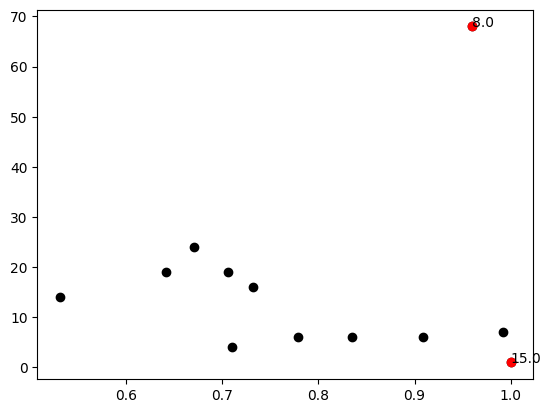

Optimal resolutions: [0.5, 1.9000000000000001]


array([1., 2., 3., 4., 5., 6., 7., 8.])

In [7]:
cluster = scl.cluster(df, method="multiK", **params)
np.unique(cluster)

In [8]:
cluster = pd.DataFrame(cluster, columns=['cluster'])
cluster.to_csv('success_cls_multik_scl.csv')

### scSHC

In [9]:
cluster = scl.cluster(df, method="scSHC", n_jobs=1)
np.unique(cluster)

Removed 0 cells and 4 genes in QC
ClusterID: 5946, Test Shape: (2974, 12082)
Mean: 43.29263949217574 Std: 0.4310169587067355 Score: 74.75003465239753
ClusterID: 5945, Test Shape: (1127, 11940)
Mean: 42.91428466513328 Std: 0.3289568668952743 Score: 46.50145674125016
ClusterID: 5942, Test Shape: (469, 11595)
Mean: 30.300128350275344 Std: 0.19911875883530009 Score: 29.868477817845104
CLUSTER IDENTIFIED; Significance: 0.9849132161184262, Total clusters: 1
ClusterID: 5940, Test Shape: (658, 11422)
Mean: 34.69388531605087 Std: 0.24909348366721928 Score: 33.940655126743785
CLUSTER IDENTIFIED; Significance: 0.9987522459298093, Total clusters: 2
ClusterID: 5944, Test Shape: (1847, 11963)
Mean: 43.83287747066404 Std: 0.2610076265860052 Score: 55.87252875895716
ClusterID: 5943, Test Shape: (574, 11446)
Mean: 33.34836990611843 Std: 0.5292271489721245 Score: 31.559678275613447
CLUSTER IDENTIFIED; Significance: 0.9996373312453875, Total clusters: 3
ClusterID: 5939, Test Shape: (1273, 11827)
Mean: 44

array([0., 1., 2., 3.])

In [10]:
cluster = pd.DataFrame(cluster, columns=['cluster'])
cluster.to_csv('success_cls_scshc_scl.csv')

### Etc

In [ ]:
from clusim.clustering import Clustering
import clusim.sim as sim

In [ ]:
df = pd.read_csv("data/sim_T_muris/imbalanced/tmp_3.csv.gz")

In [ ]:
true_cls = Clustering().from_membership_list(df['cell'])
scl_cls = Clustering().from_membership_list(cluster['cluster'])
chooser_cls = Clustering().from_membership_list(pd.read_csv('fail_cls_chooser.csv')['x'])
scl_score = sim.element_sim(true_cls, scl_cls)
chooser_score = sim.element_sim(true_cls, chooser_cls)

In [ ]:
scl_score, chooser_score

(1.0, 0.38119248409273737)

# Investigate

In [ ]:
from scLENS.clustering import multiK

In [ ]:
scl_check = scl_scores.drop(['MultiK_RandIndex', 'MultiK_NormMI'], axis=1)[scl_scores['MultiK_ECC'] < noscl_scores['MultiK_ECC']]
noscl_check = noscl_scores.drop(['MultiK_RandIndex', 'MultiK_NormMI'], axis=1)[scl_scores['MultiK_ECC'] < noscl_scores['MultiK_ECC']]
scl_check

KeyError: "['MultiK_RandIndex', 'MultiK_NormMI'] not found in axis"

In [ ]:
noscl_check

In [ ]:
for dataset in scl_check.index:
  df = pd.read_csv(dataset)
  y_true = df['cell']
  df = df.drop(['cell'], axis=1)

  scl = scLENS(device=torch.device('cuda:0'))
  scl.preprocess(df)
  X_transform_scl = scl.fit_transform()
  mltk_scl = scl.cluster(df, method='multiK', **params)

  adata = anndata.AnnData(X=df, obs=pd.DataFrame(y_true))

  sc.pp.filter_cells(adata, min_genes=200)
  sc.pp.filter_genes(adata, min_cells=3)

  sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

  adata = adata[adata.obs.n_genes_by_counts < 2500, :]

  sc.pp.normalize_total(adata, target_sum=1e4)
  sc.pp.log1p(adata)
  sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
  adata = adata[:, adata.var.highly_variable]
  sc.pp.scale(adata, max_value=10)

  sc.tl.pca(adata, svd_solver='arpack')

  X_transform_noscl = adata.obsm['X_pca']
  y_true_noscl = adata.obs['cell']

  res = multiK(X_transform_noscl, **params)

  mltk_noscl = find_clusters(X_transform_noscl,
                             n_neighbors=20,
                             min_weight=1/15,
                             res=res,
                             n_iterations=-1)

  display_mappings(X_transform_scl, [y_true, mltk_scl], ['True', 'scLENS MultiK'])
  display_mappings(X_transform_noscl, [y_true_noscl, mltk_noscl], ['True', 'No scLENS MultiK'])